<center>Computational Statistics, Marina Khismatullina | Summer 2021, Bonn University | 14/07/2021 <br> 
        Nargiz Ahmadova, Xingyu Tao and Sven Jacobs (Group 18)</center> 

***
    
# <center>Problem Set 09</center>

The goal of the problem set is to compare the performance of causal random forests with the performance of alternative treatment effect estimators, based on simulated data derived from the [National Study of Learning Mindsets (NSLM)](https://www.icpsr.umich.edu/web/DAIRL/studies/37353).

## Preparation

In [3]:
# Packages
library(tidyverse)   # Collection of packages for data science
library(fishmethods) # Provides the remp function (RNG from ECDF)
library(Hmisc)       # Plots matrix of histograms
library(grf)         # Forest-based statistical estimation and inference
library(estimatr)    # Cluster-robust OLS estimation

# Seed
set.seed(123)

## Background information

Data basis: National Study of Learning Mindsets (NSLM)
* RCT conducted in 76 US high schools, involved ca. 16,000 students
* Research question: <br>
  Do positive growth mindset messages (= treatment), presented to students at the beginning of high school, help to improve       students' academic achievement? 
* Which groups of students benefit the most from treatment?

DGP and questions from Problem Set:
* Workshop on causal inference: organizers simulated data from NSLM and invited prominent scholars to tackle the three questions
* Our simulation setup is inspired by the original simulation described in Carvalho et al. (2019)

\begin{align}
y_{ij}^{\text{obs}} &= \alpha_j + \beta X + \left[ \tau( x_{j1}, x_{j2}, c_{ij1} ) + \gamma_j \right]*w_{ij} + \epsilon_{ij}\\[10pt]
\tau( x_{1}, x_{2}, c_{1} ) &= 0.23 + 0.05*\mathbb{1}(x_1 < 0.07) - 0.05*\mathbb{1}(x_2 < -0.69) - 0.08*\mathbb{1}(c_1 \in \{1, 13, 14\}) \\
\alpha_j &\sim \mathcal{N}\left(0, \, 0.15^{2}\right) \\
\gamma_j &\sim \mathcal{N}\left(0, \, 0.10^{2}\right) \\
\epsilon_{ij} &\sim \mathcal{N}\left(0, \, 0.5^{2}\right)
\end{align}

<a id="table1"></a>
<center>Table 1: Variables measured in the National Study of Learning Mindsets</center>

| Variable | Definition                                                  | Level   | Type        |
|:---------|:------------------------------------------------------------|:--------|:------------|
| S3       | Expectation for future succes                               | Student | Categorical |
| C1       | Race/Ethnicity                                              | Student | Categorical |
| C2       | Gender                                                      | Student | Categorical |
| C3       | First-generation status (college attendance)                | Student | Categorical |
| XC       | Urbanicity                                                  | School  | Categorical |
| X1       | Students' fixed mindsets                                    | School  | Real-valued |
| X2       | Achievement level                                           | School  | Real-valued |
| X3       | Racial/ethnic minority composition                          | School  | Real-valued |
| X4       | Poverty concentration                                       | School  | Real-valued |
| X5       | Size, i.e., total number of students                        | School  | Real-valued |
| Y        | Post-treatment outcome: A continuous measure of achievement | Student | Real-valued |
| W        | Treatment: Information on growth mindset                    | Student | Categorical |

## Exercise 1

### 1.1)
*Simulate the data set as described above. The outcome is determined solely by the included covariates and the treatment W. You may choose the scale and range of all variables, as well as the shares represented in the categorical variables.*

In [4]:
# Load data
data <- read.csv("data/synthetic_data.csv")

In [5]:
simulate_data <- function(N) { # N refers to the number of schools
    
    # Simulate number of students per school
    s_size <- as.data.frame(table(data$schoolid))$Freq
    s_size_sim <- round(remp(N, as.numeric(s_size)))
    
    # Simulate values of XC (Urbanicity)
    XC_collapsed <- data %>% group_by(schoolid) %>% slice(1) %>% pull(XC)
    XC_freq <- as.data.frame(prop.table(table(XC_collapsed)))$Freq
    XC_sim <- sample(c(0, 1, 2, 3, 4), N, replace = TRUE, prob = XC_freq)

    # Simulate real-valued school-level variables
    X1_sim <- remp(N, unique(data$X1))
    X2_sim <- remp(N, unique(data$X2))
    X3_sim <- remp(N, unique(data$X3))
    X4_sim <- remp(N, unique(data$X4))
    X5_sim <- remp(N, unique(data$X5))

    # Extract shares of categorical student-level variables from original data
    S3_freq <- as.data.frame(prop.table(table(data$S3)))$Freq
    C1_freq <- as.data.frame(prop.table(table(data$C1)))$Freq
    C3_freq <- as.data.frame(prop.table(table(data$C3)))$Freq

    # Noise on school-level for cluster structure
    alpha <- rnorm(N, 0, 0.15)
    gamma <- rnorm(N, 0, 0.10)

    list_df <- list()
    
    # Simulate data for each school
    for (j in 1:N) {
        df <- setNames(data.frame(matrix(nrow = s_size_sim[j], ncol = 13)), 
                       c("schoolid", "W", "Y", "S3", "C1", "C2", "C3", "XC", "X1", "X2", "X3", "X4", "X5"))
    
        df$schoolid <- rep(j, nrow(df))
    
        # Simulate categorical student-level variables and assign treatment
        df$W <- sample(c(1, 0), nrow(df), replace = TRUE, prob = c(1/3, 2/3))
        df$S3 <- sample(1:7, nrow(df), replace = TRUE, prob = S3_freq)
        df$C1 <- sample(1:15, nrow(df), replace = TRUE, prob = C1_freq)
        df$C2 <- sample(c(1, 2), nrow(df), replace = TRUE, prob = c(1/2, 1/2))
        df$C3 <- sample(c(0, 1), nrow(df), replace = TRUE, prob = C3_freq)
    
        df$XC <- rep(XC_sim[j], nrow(df))
        df$X1 <- rep(X1_sim[j], nrow(df))
        df$X2 <- rep(X2_sim[j], nrow(df))
        df$X3 <- rep(X3_sim[j], nrow(df))
        df$X4 <- rep(X4_sim[j], nrow(df))
        df$X5 <- rep(X5_sim[j], nrow(df))
    
        # Individual noise
        eps <- rnorm(nrow(df), 0, 0.5)
    
        # Simulate the outcome Y (influence of covariates is based on a cluster-robust linear regression, see also above)
        for (i in 1:nrow(df)) {
            df$Y[i] <- alpha[j] +
                       -1.00 + 0.24*df$S3[i] - 0.17*df$C2[i] - 0.09*df$C3[i] - 0.08*df$X1[i] - 0.02*df$X2[i] + 0.03*df$X3[i] - 0.05*df$X5[i] -
                       0.16*ifelse(df$XC[i] == 1 | df$XC[i] == 3, 1, 0) + 0.13*ifelse(df$C1[i] == 5 | df$C1[i] == 12 | df$C1[i] == 15, 1, 0) -
                       0.12*ifelse(is.element(df$C1[i], c(3, 4, 6, 7, 9, 10, 11, 13)), 1, 0) +
                       (gamma[j] + 0.23 + 0.05*ifelse(df$X1[i] < 0.07, 1, 0) - 0.05*ifelse(df$X2[i] < -0.69, 1, 0) - 0.08*ifelse(df$C1[i] == 1 | df$C1[i] == 13 | df$C1[i] == 14, 1, 0)) * df$W[i] +
                       eps[i]
        }
    
    list_df[[j]] <- df
    }

    # Merge data
    sim_data <- do.call("rbind", list_df)

    return(sim_data)
}

In [6]:
sim_data <- simulate_data(N = 76)
Y <- sim_data$Y
W <- sim_data$W
X <- sim_data[, -(1:3)]
schoolid <- sim_data$schoolid

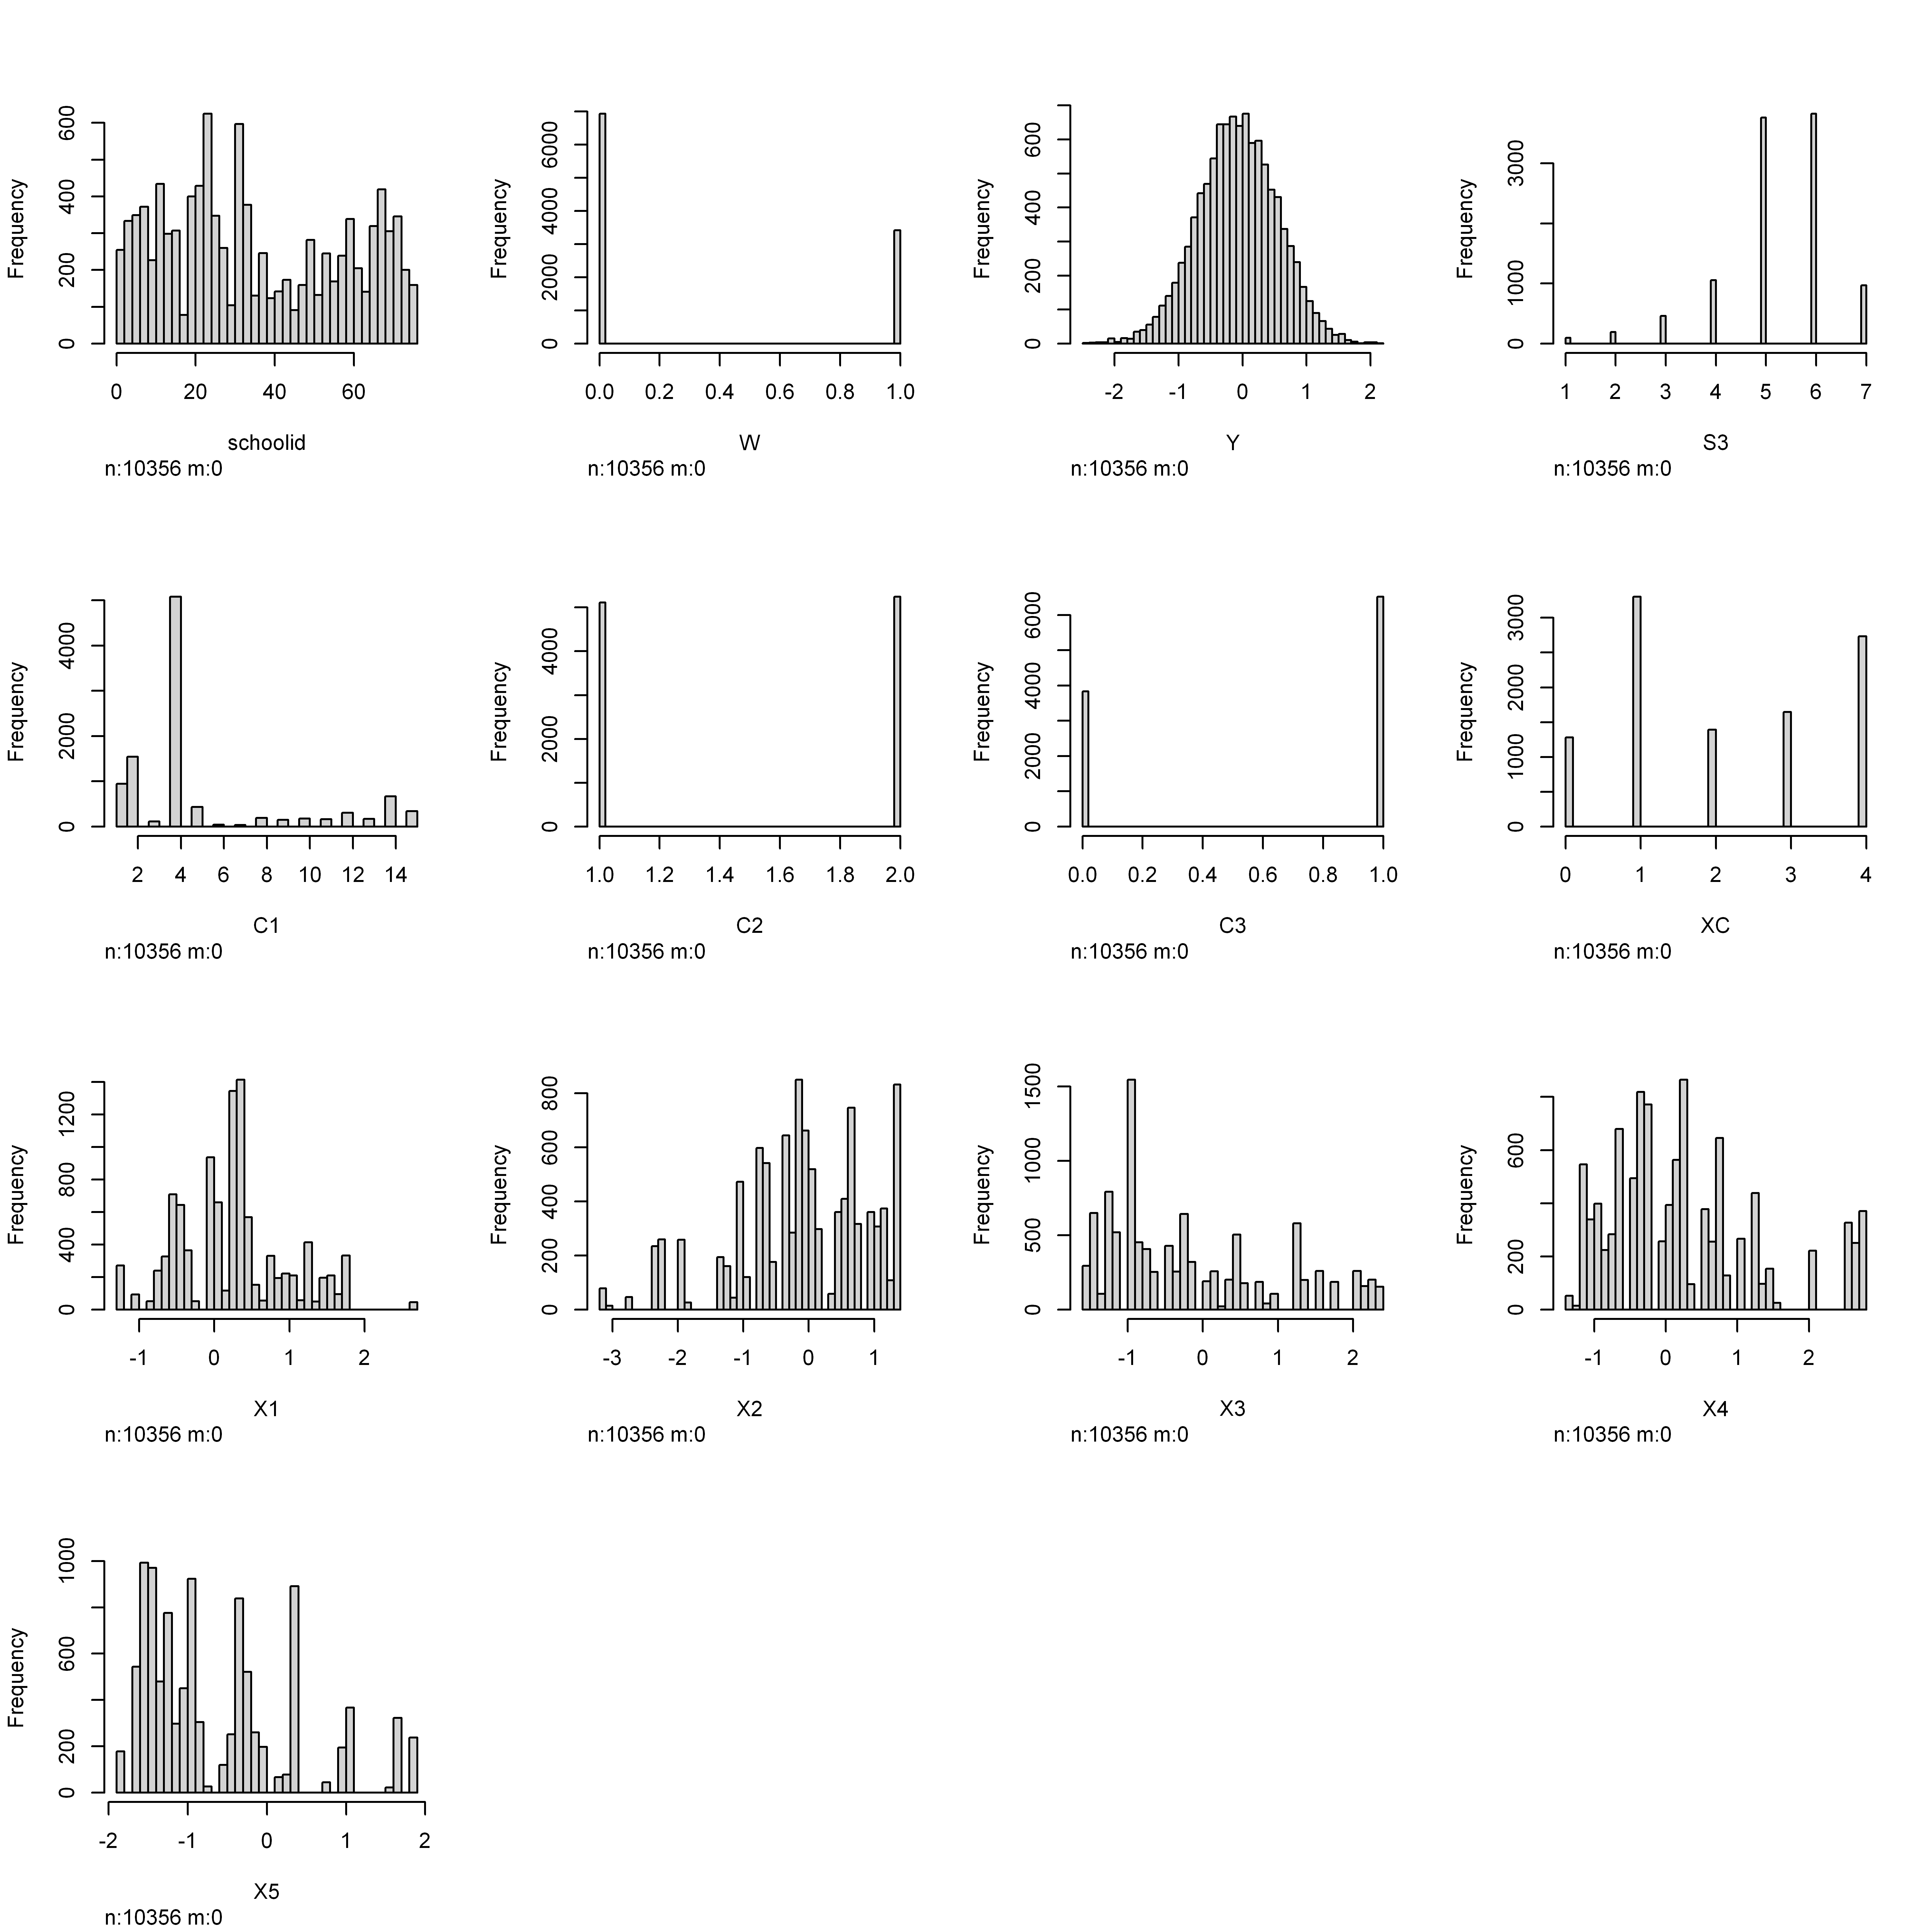

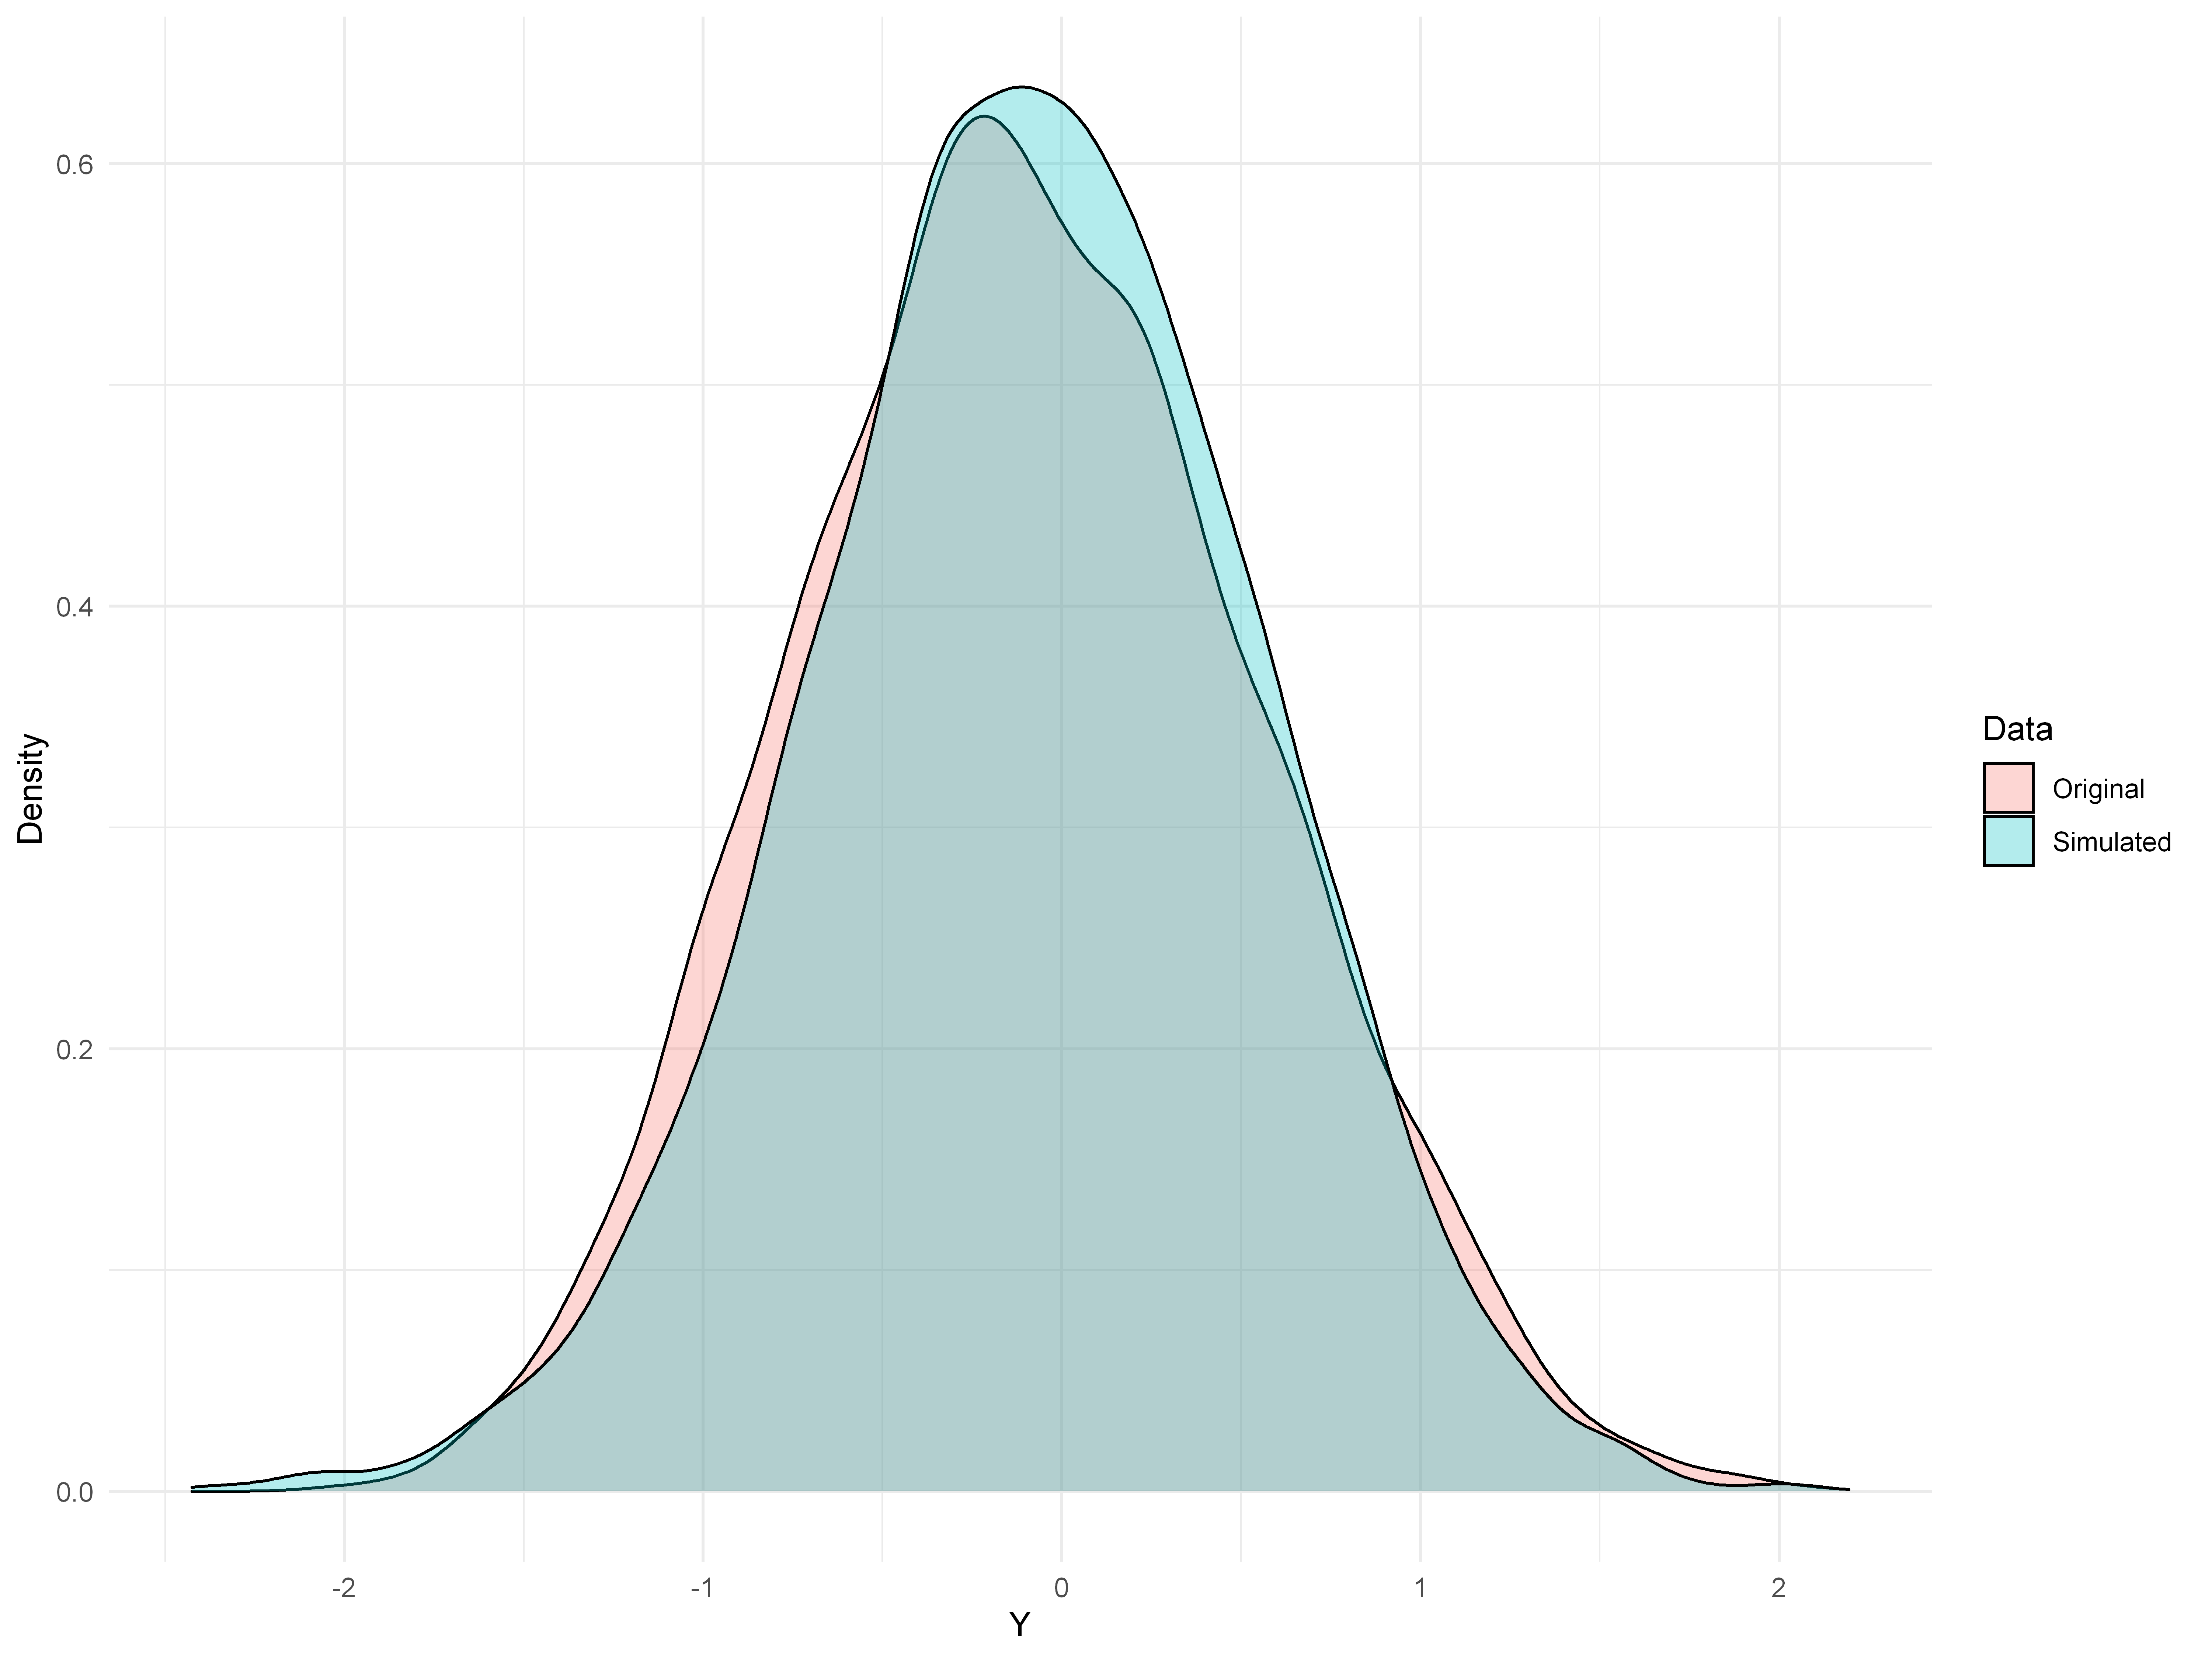

In [7]:
options(repr.plot.res = 600, repr.plot.height = 10, repr.plot.width = 10) # Adjusting plotting options

# Histograms for all simulated variables
hist.data.frame(sim_data, n.unique = 2)

hist_data <- setNames(as.data.frame(data$Y), "Y")
hist_sim_data <- setNames(as.data.frame(sim_data$Y), "Y")
hist_data$Data <- "Original"
hist_sim_data$Data <- "Simulated"
hist_comb <- rbind(hist_data, hist_sim_data)

options(repr.plot.res = 600, repr.plot.height = 7.5, repr.plot.width = 10)

# Estimated densities for the outcome variable Y
ggplot(hist_comb, aes(Y, fill = Data)) + 
    geom_density(alpha = 0.3) +
    ylab("Density") + 
    theme_minimal()

### Which theoretical results do we have?

\begin{align}
\tau( x_{1}, x_{2}, c_{1} ) &= 0.23 + 0.05*\mathbb{1}(x_1 < 0.07) - 0.05*\mathbb{1}(x_2 < -0.69) - 0.08*\mathbb{1}(c_1 \in \{1, 13, 14\})
\end{align}

**Average Treatment Effect (ATE)**

Relatively large positive effect of treatment (true ATE = 0.2091)

**Treatment effect heterogeneity / moderation**

<center>Three treatment moderators</center> 

| Moderator | Definition               |                                                  |
|:----------|:-------------------------|:-------------------------------------------------|
| X1        | Students' fixed mindsets | Higher values correspond to a more fixed mindset |
| X2        | School achievement level | Higher values correspond to higher achievement   |
| C1        | Student's race/ethnicity |                                                  |

1. Students in schools with a less fixed mindset exhibit a higher treatment effect (lower $X1$ $\implies$ higher $\tau$)
2. Students in high-achievement schools show a higher treatment effect (higher $X2$ $\implies$ higher $\tau$) <br>
   $\rightarrow$ No "Goldilocks" effect
3. Treatment effect varies across race/ethnicity

### 1.2)
*Compare the results from a linear regression estimate of the treatment effect and the causal (random) forest to answer question 1 from above.*

In [8]:
# Expand out categorical variables via one-hot encoding (required for grf) 
C1_exp <- model.matrix(~ as.factor(X$C1) + 0)
XC_exp <- model.matrix(~ as.factor(X$XC) + 0)
X <- cbind(X[-c(2, 5)], C1_exp, XC_exp)

In [9]:
# First stage: Two separate forests to estimate outcome and propensity functions

# Random forest to estimate the conditional mean function E[Y_i | X_i = x] 
Y_forest <- regression_forest(X, Y, clusters = schoolid,
                              equalize.cluster.weights = TRUE) # Each school receives equal weight in ATE estimation
# OOB prediction
Y_hat <- predict(Y_forest)$predictions

# Random forest to estimate the propensity score function P[W_i | X_i = x] 
W_forest <- regression_forest(X, W, clusters = schoolid, equalize.cluster.weights = TRUE)
# OOB prediction
W_hat <- predict(W_forest)$predictions

In [10]:
# Second stage: Grow a causal forest using the OOB predictions

# Pilot random forest, trained on all features (no tuning)
cf_pilot <- causal_forest(X, Y, W,
                          Y.hat = Y_hat, W.hat = W_hat,
                          clusters = schoolid, equalize.cluster.weights = TRUE)

var_imp <- variable_importance(cf_pilot) # Weighted sum of how many times a feature was split on at each depth in the forest
select_index <- which(var_imp > mean(var_imp))

# Final causal random forest (tuning based on CV)
cf <- causal_forest(X[, select_index], Y, W,
                    Y.hat = Y_hat, W.hat = W_hat,
                    clusters = schoolid, equalize.cluster.weights = TRUE,
                    tune.parameters = "all")

# Prediction of individual treatment effect
tau_hat <- predict(cf)$predictions

In [11]:
# Average Treatment Effect (ATE) E[Y(1) - Y(0)]

# Causal random forest
ATE <- average_treatment_effect(cf)

# Linear regression (danger of dummy variable trap)
lin_reg <- lm_robust(Y ~ W + ., data = X[-c(9, 24)], clusters = schoolid, se_type = "CR0")

paste("Causal forest: 95% CI for the ATE:", round(ATE[1], 4),
       "+/-", round(qnorm(0.975)*ATE[2], 4))
paste("Linear regression: 95% CI for the ATE:", round(lin_reg$coefficients[2], 4),
      "+/-", round(qnorm(0.975)*lin_reg$std.error[2], 4))

[1] "Causal forest: 95% CI for the ATE: 0.2164 +/- 0.0378"

[1] "Linear regression: 95% CI for the ATE: 0.2134 +/- 0.0292"

Both estimates reveal the overall effectiveness of the intervention precisely.

The assumptions required for applying linear regression when doing causal inference are:

1. The treatment $W$ is as good as randomized given covariates (there are no unmeasured confounders).
2. The treatment effect $\tau$ is constant.
3. The measured confounders have a linear effect on the outcome.

## Exercise 2

*Induce moderation of the treatment effect and evaluate the relative performance of causal (random) forests and a linear model with simple interactions for four different sample sizes.*

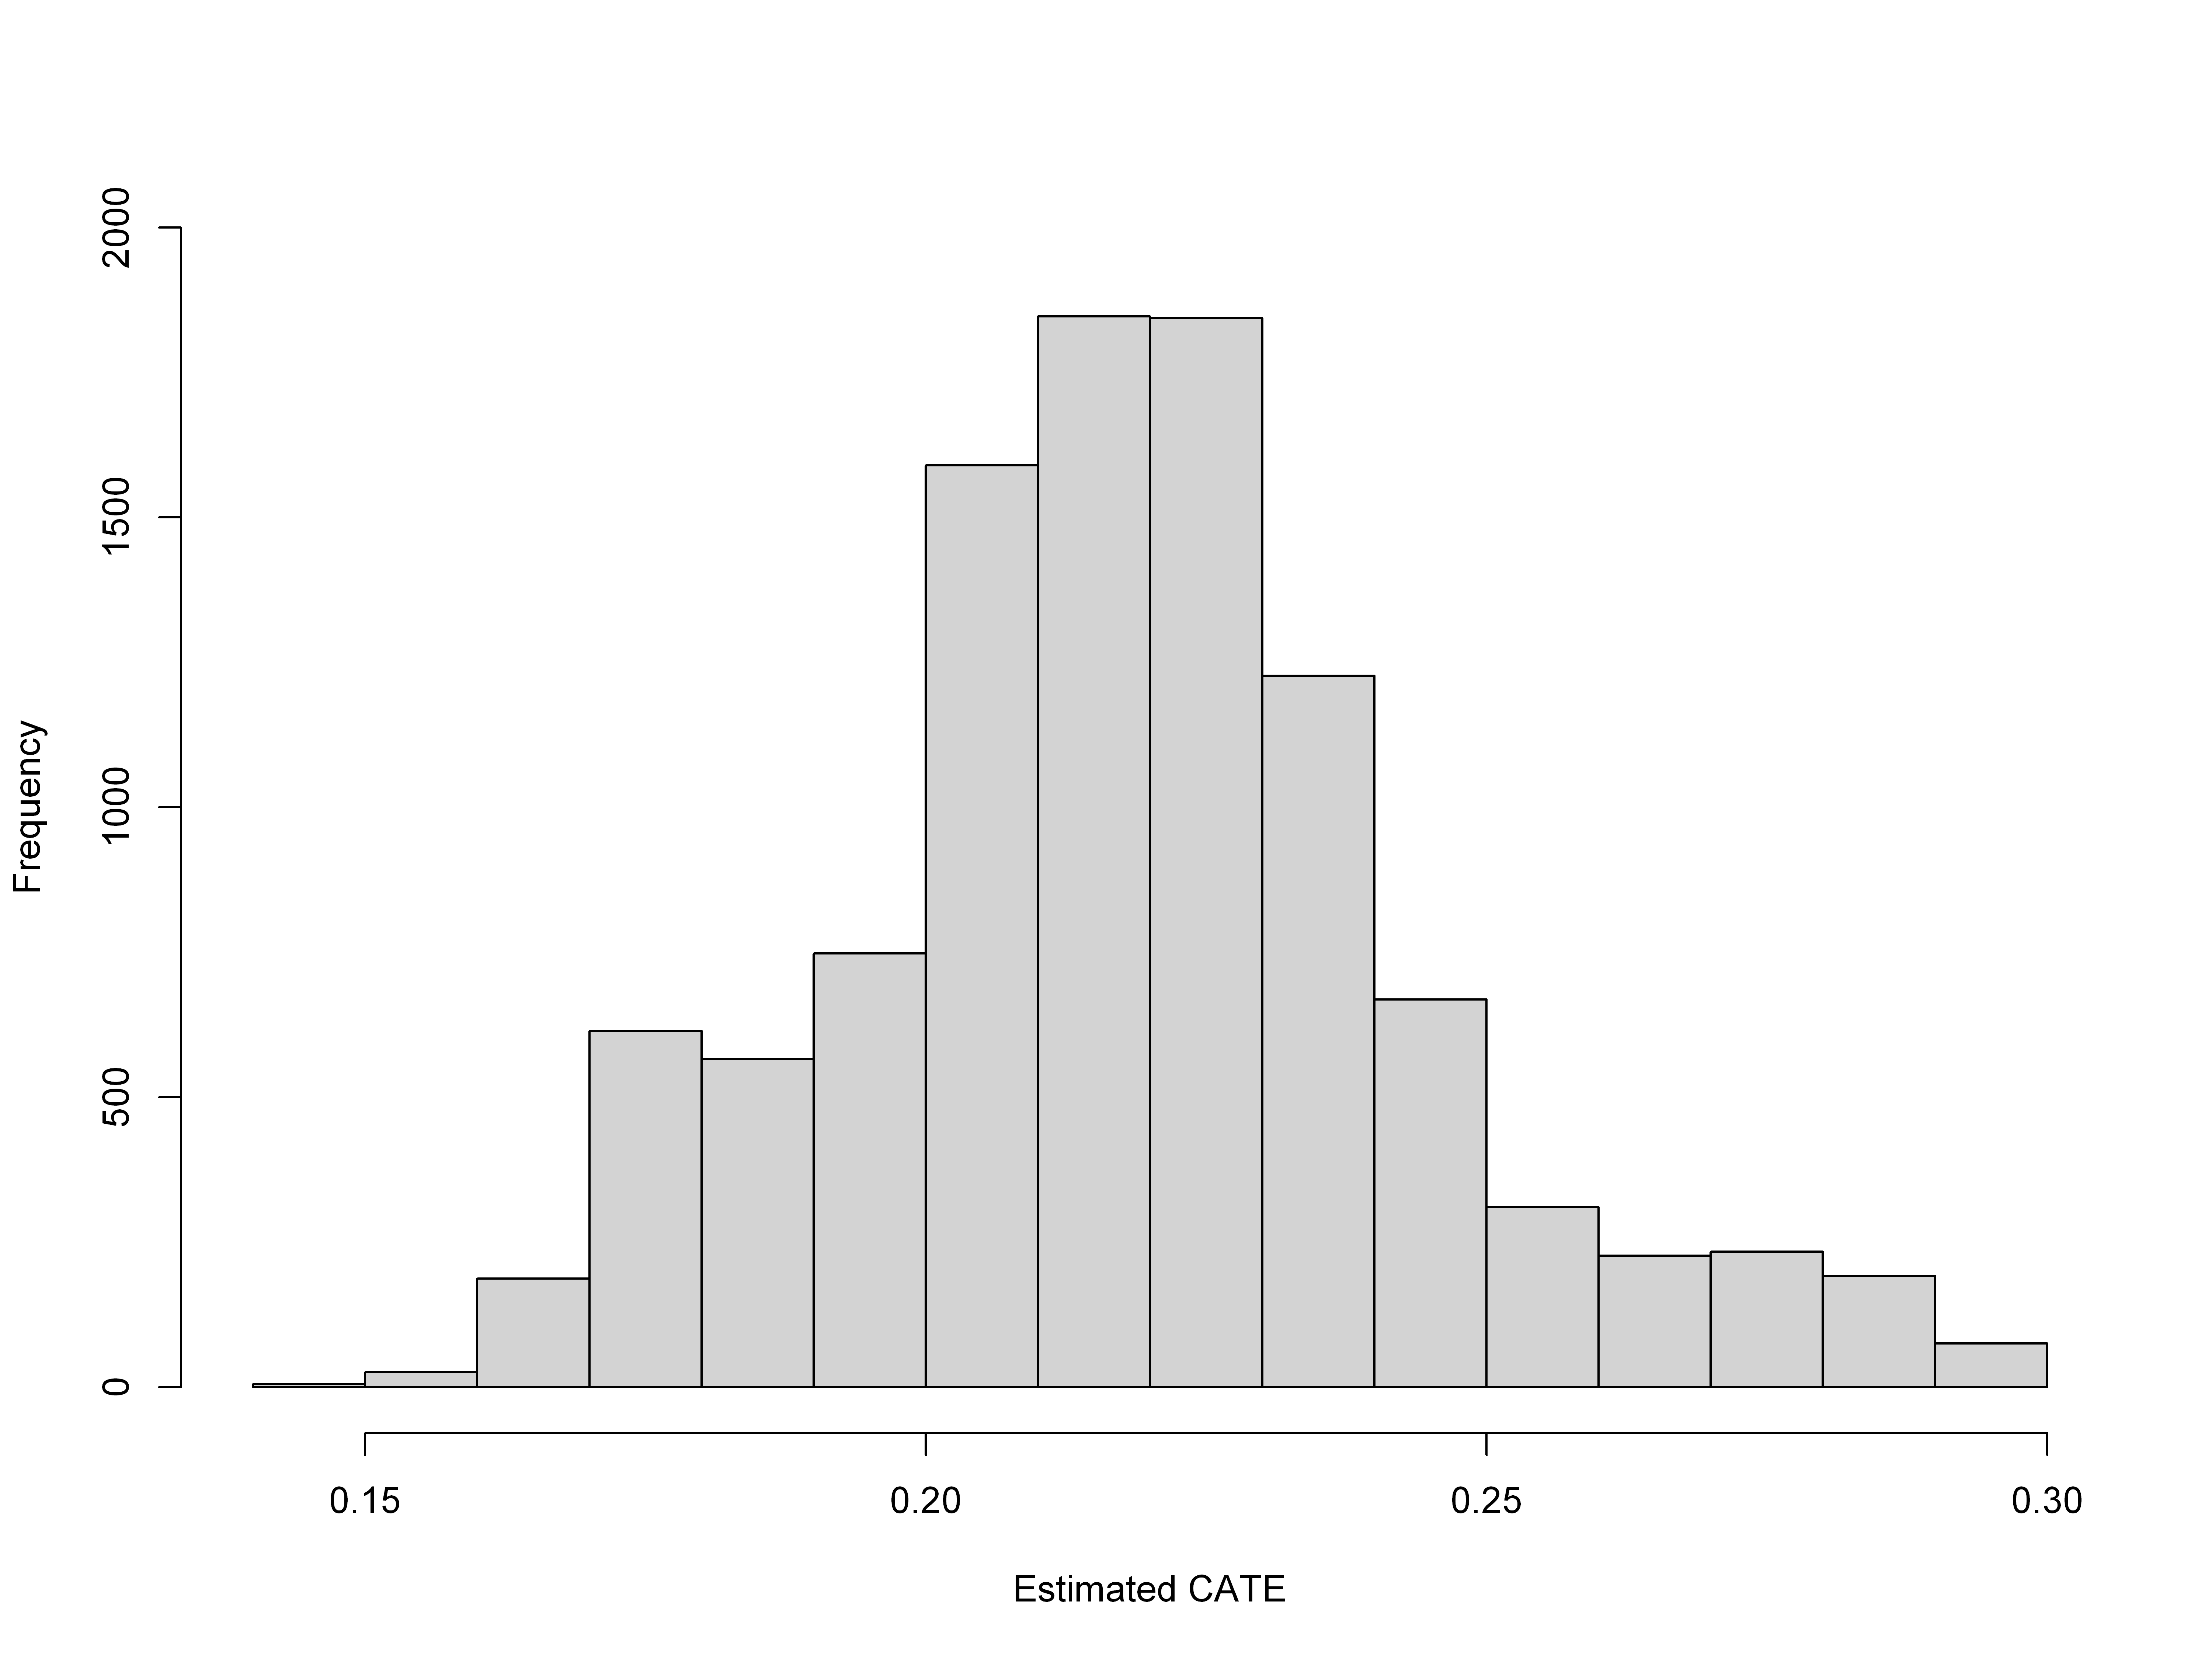

In [12]:
# Histogram of the estimated CATE
hist(tau_hat, main = "", xlab = "Estimated CATE", ylim = c(0, 2000))

The plot shows that variation in the CATE is present. However, this does not necessarily mean that treatment moderation by any of the above covariates exists.

**Omnibus test for treatment heterogeneity:**

In [13]:
# Compare regions with high and low estimated CATEs
high_effect = tau_hat > median(tau_hat)
ate_high = average_treatment_effect(cf, subset = high_effect)
ate_low = average_treatment_effect(cf, subset = !high_effect)

paste("95% CI for difference in ATE:",
      round(ate_high[1] - ate_low[1], 4), "+/-",
      round(qnorm(0.975) * sqrt(ate_high[2]^2 + ate_low[2]^2), 4))

[1] "95% CI for difference in ATE: 0.0408 +/- 0.0769"

Interpretation:
* The estimate is consistent with the presence of heterogeneity, but the detection is not significant.
* Causal forests do not identify subgroups with effects that (clearly) stand out.
* But maybe tests that focus on specific variables (e.g., X1) have more power. $\rightarrow$ Analysis below

<p style="padding: 10px; border: 1px solid black">
<strong>Note:</strong>
In what follows, we do not provide formal tests in the context of causal forests for single treatment moderators. This would require a deeper mathematical discussion. A description of such tests is given in Athey and Wager (2019). 
</p>

### 2.1)
*Sequentially introduce higher level interactions in the DGP to reproduce a scenario outlined in question 2.*

In [14]:
CATE_X1_X2 <- function(N) {
    sim_data <- simulate_data(N = N)
    Y <- sim_data$Y
    W <- sim_data$W
    X <- sim_data[, -(1:3)]
    schoolid <- sim_data$schoolid
    
    C1_exp <- model.matrix(~ as.factor(X$C1) + 0)
    XC_exp <- model.matrix(~ as.factor(X$XC) + 0)
    X <- cbind(X[-c(2, 5)], C1_exp, XC_exp)
    
    Y_forest <- regression_forest(X, Y, clusters = schoolid, equalize.cluster.weights = TRUE)
    Y_hat <- predict(Y_forest)$predictions
    
    W_forest <- regression_forest(X, W, clusters = schoolid, equalize.cluster.weights = TRUE)
    W_hat <- predict(W_forest)$predictions
    
    cf_pilot <- causal_forest(X, Y, W,
                              Y.hat = Y_hat, W.hat = W_hat,
                              clusters = schoolid, equalize.cluster.weights = TRUE)
    
    var_imp <- variable_importance(cf_pilot) 
    select_index <- which(var_imp > mean(var_imp))
    
    cf <- causal_forest(X[, select_index], Y, W,
                        Y.hat = Y_hat, W.hat = W_hat,
                        clusters = schoolid, equalize.cluster.weights = TRUE,
                        tune.parameters = "all")
    
    tau_hat <- predict(cf)$predictions
    
    par(mfrow = c(1, 2), oma = c(0, 0, 2, 0))
    
    ifelse(min(round(X$X1)) == -2, a <- 3, a <- 4)
    ifelse(min(round(X$X2)) == -2, b <- 3, b <- 4)
    
    boxplot(tau_hat ~ round(X$X1), xlab = "X1", ylab = "Estimated CATE")
    lines(smooth.spline(a + X[, "X1"], tau_hat, df = 4), lwd = 2, col = 4)
    abline(v = a + 0.07, lwd = 2, lty = 2, col = 2)
    boxplot(tau_hat ~ round(X$X2), xlab = "X2", ylab = "Estimated CATE")
    lines(smooth.spline(b + X[, "X2"], tau_hat, df = 4), lwd = 2, col = 4)
    abline(v = b - 0.69, lwd = 2, lty = 2, col = 2)
    
    mtext(paste("Variation with X1 and X2 for N =", N), outer = TRUE, cex = 1.5)
}

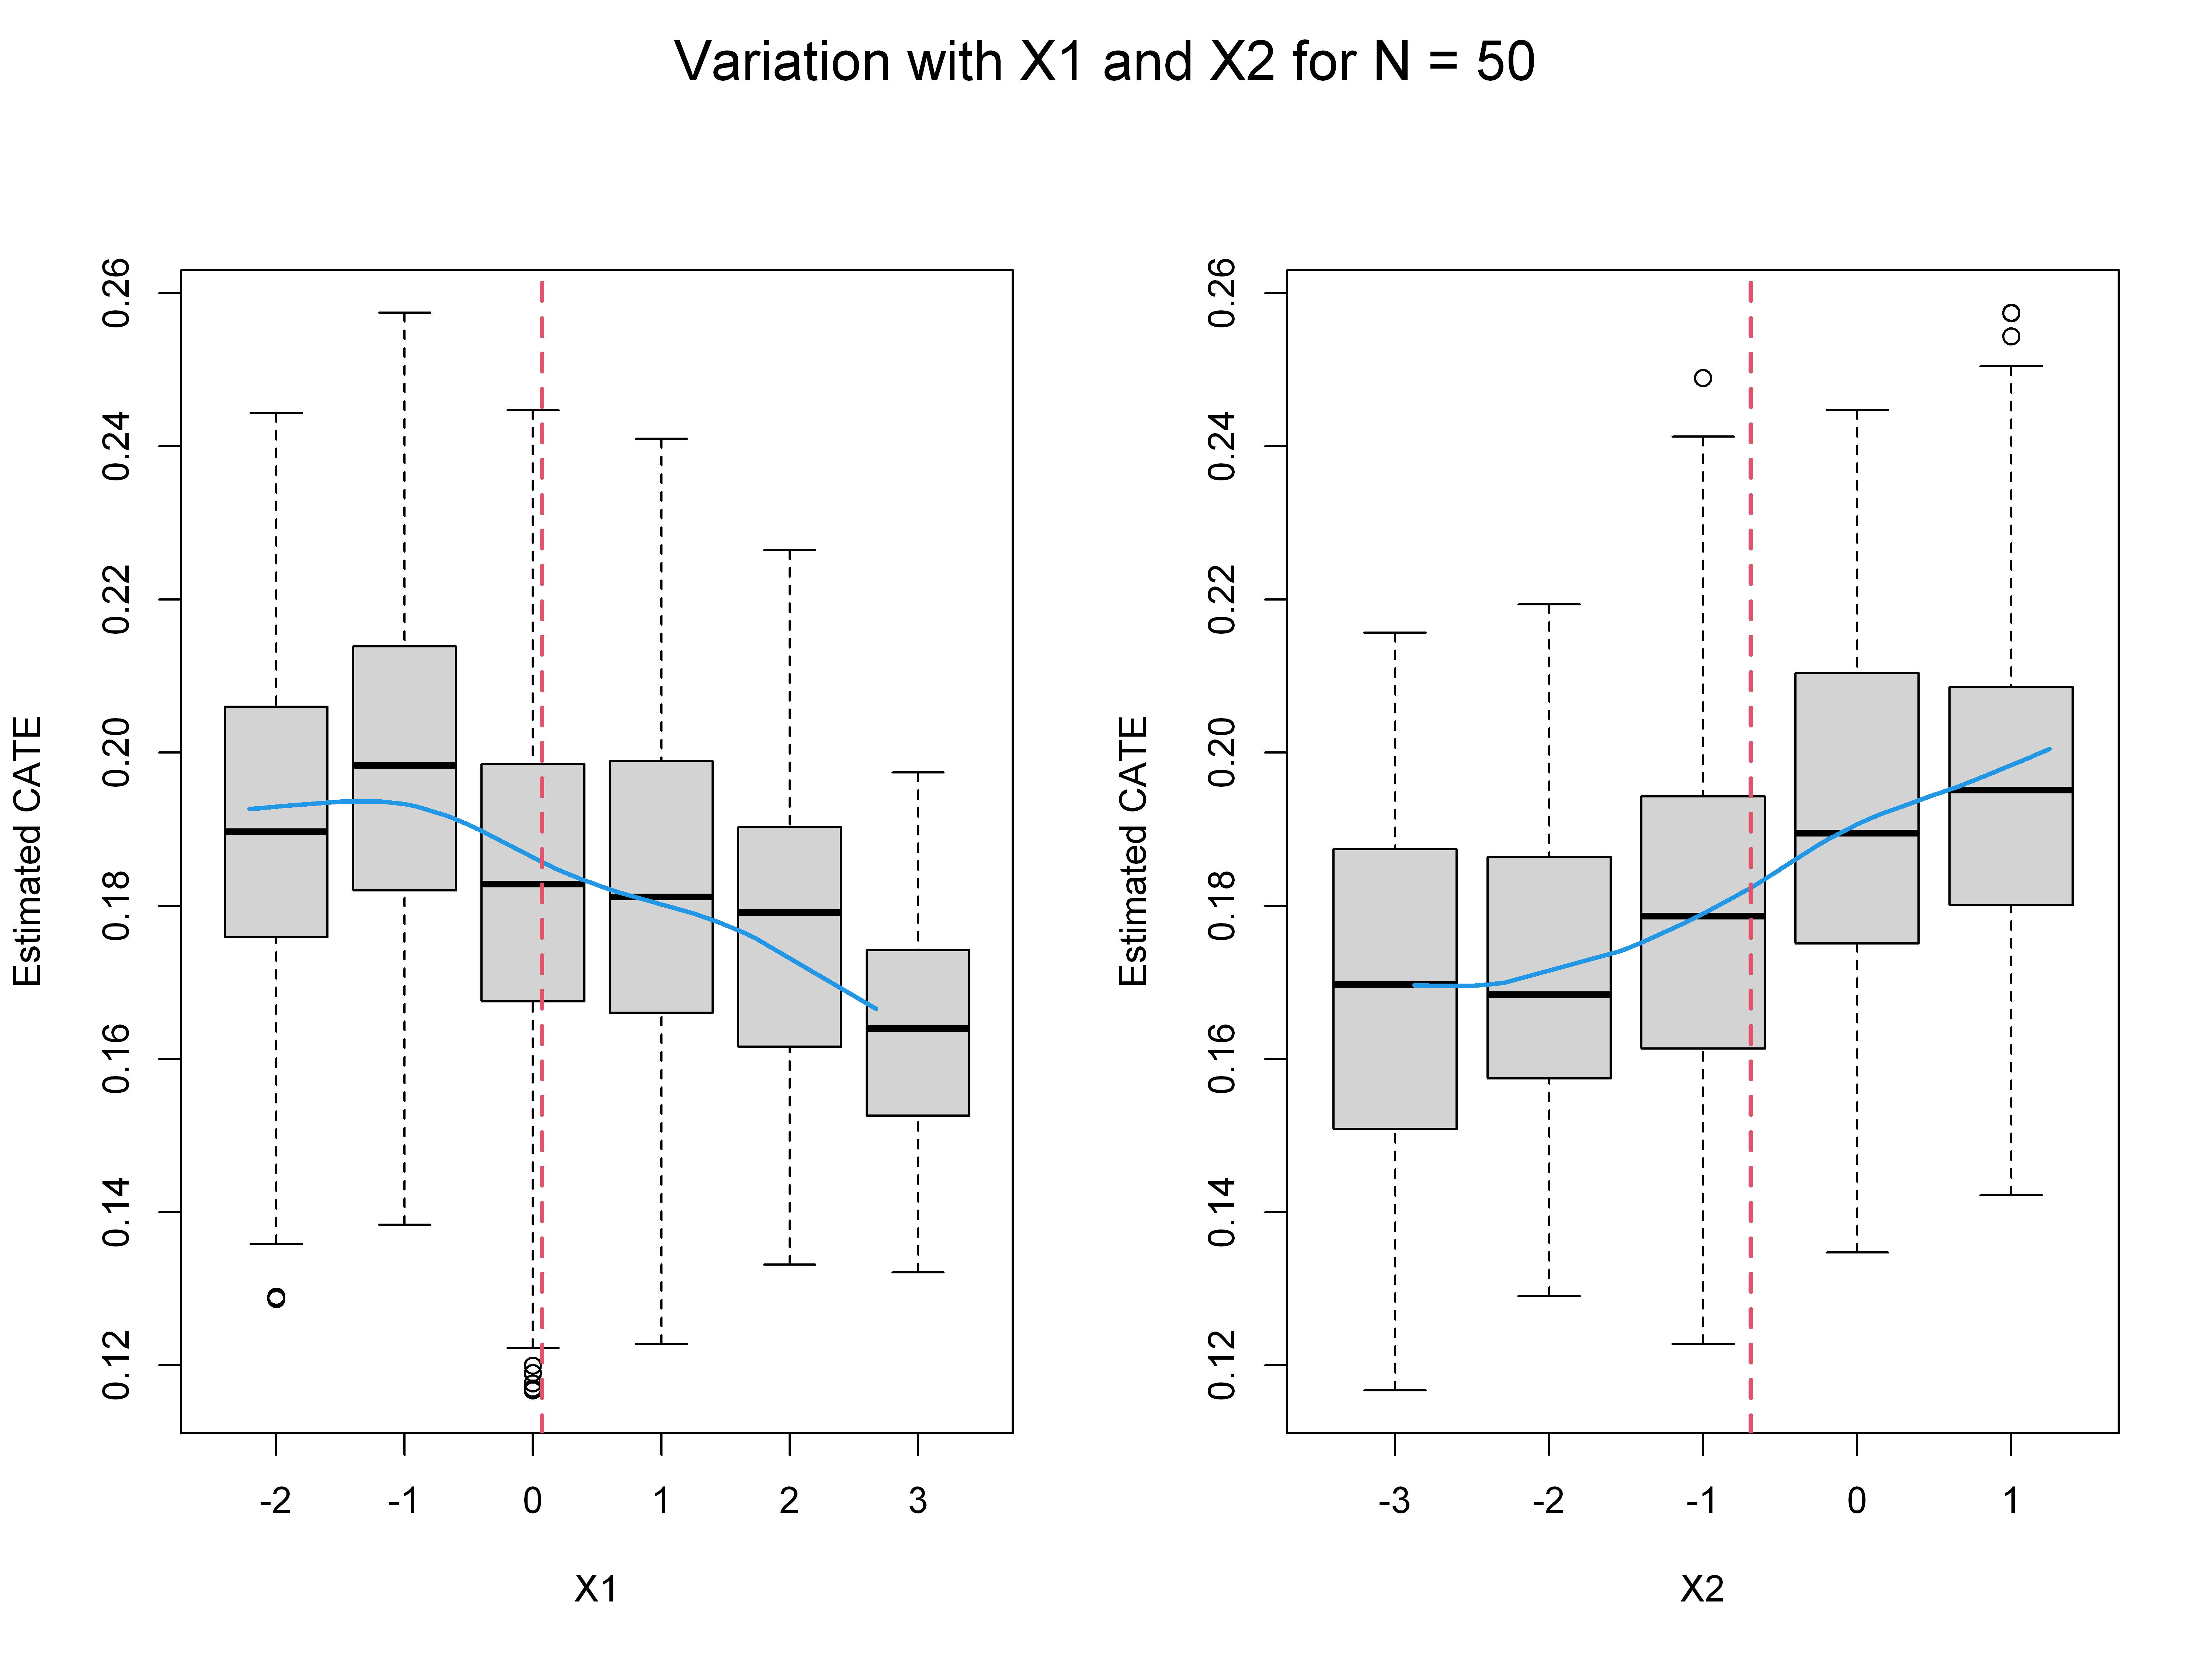

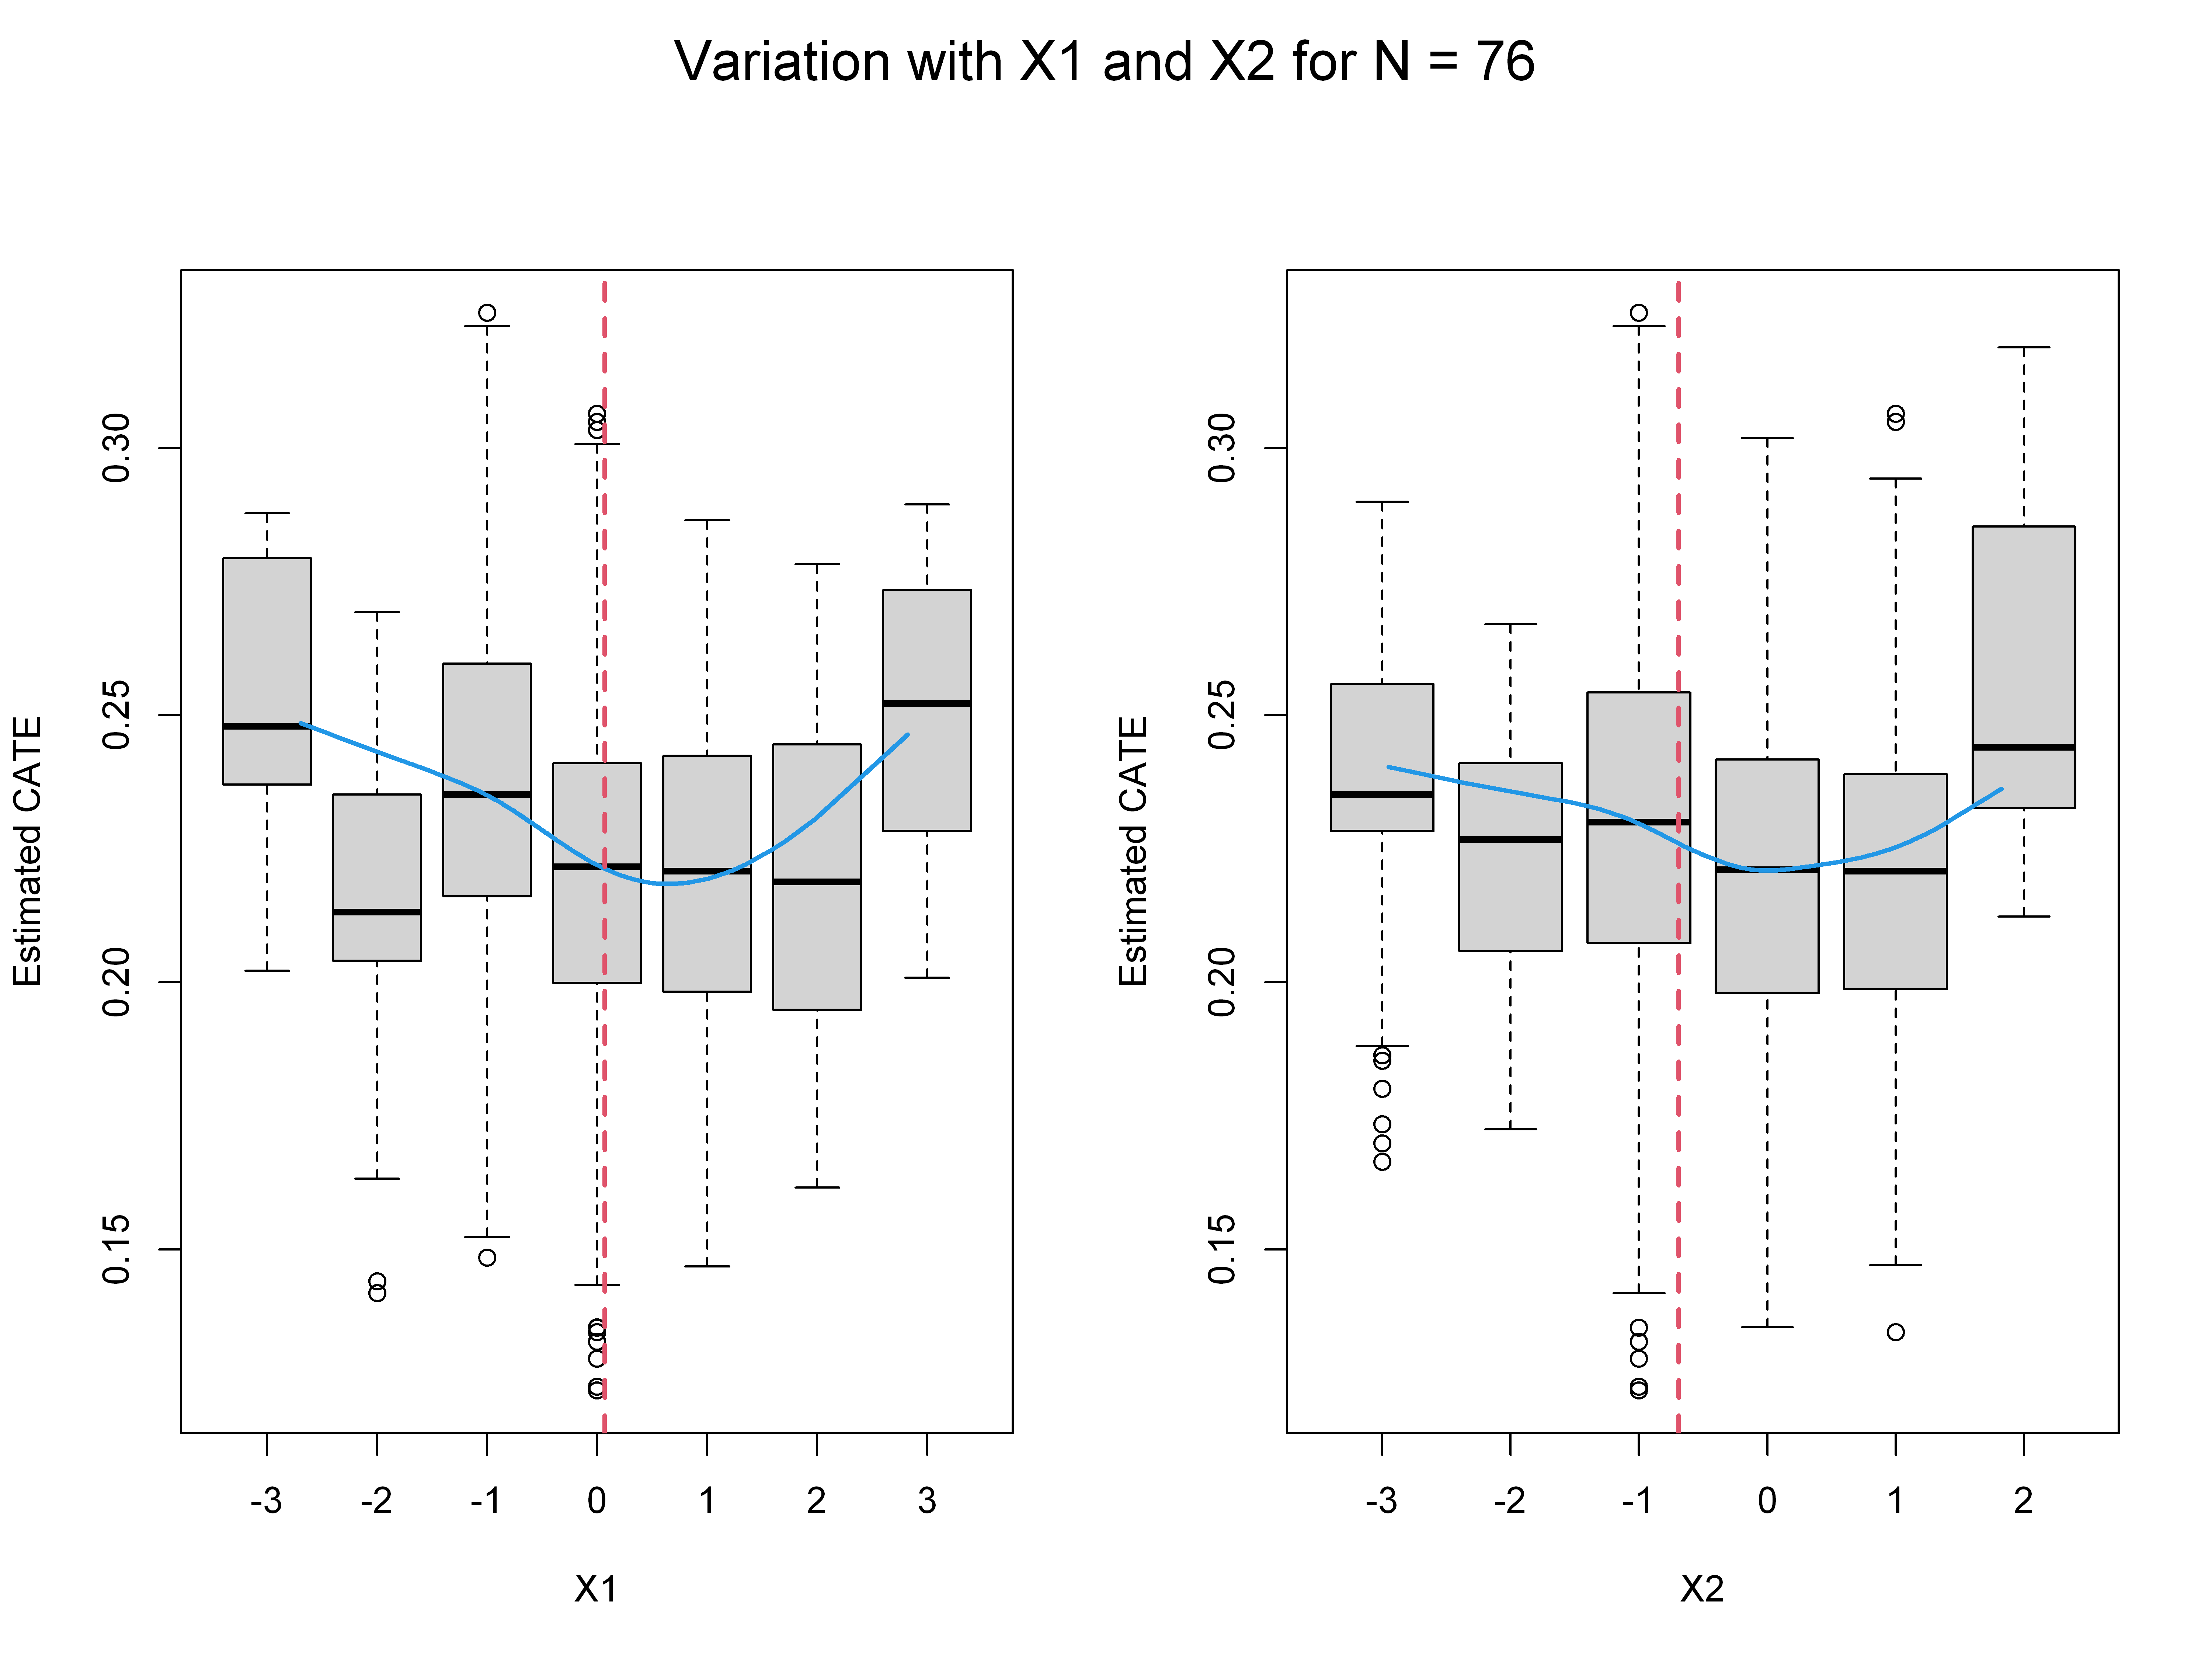

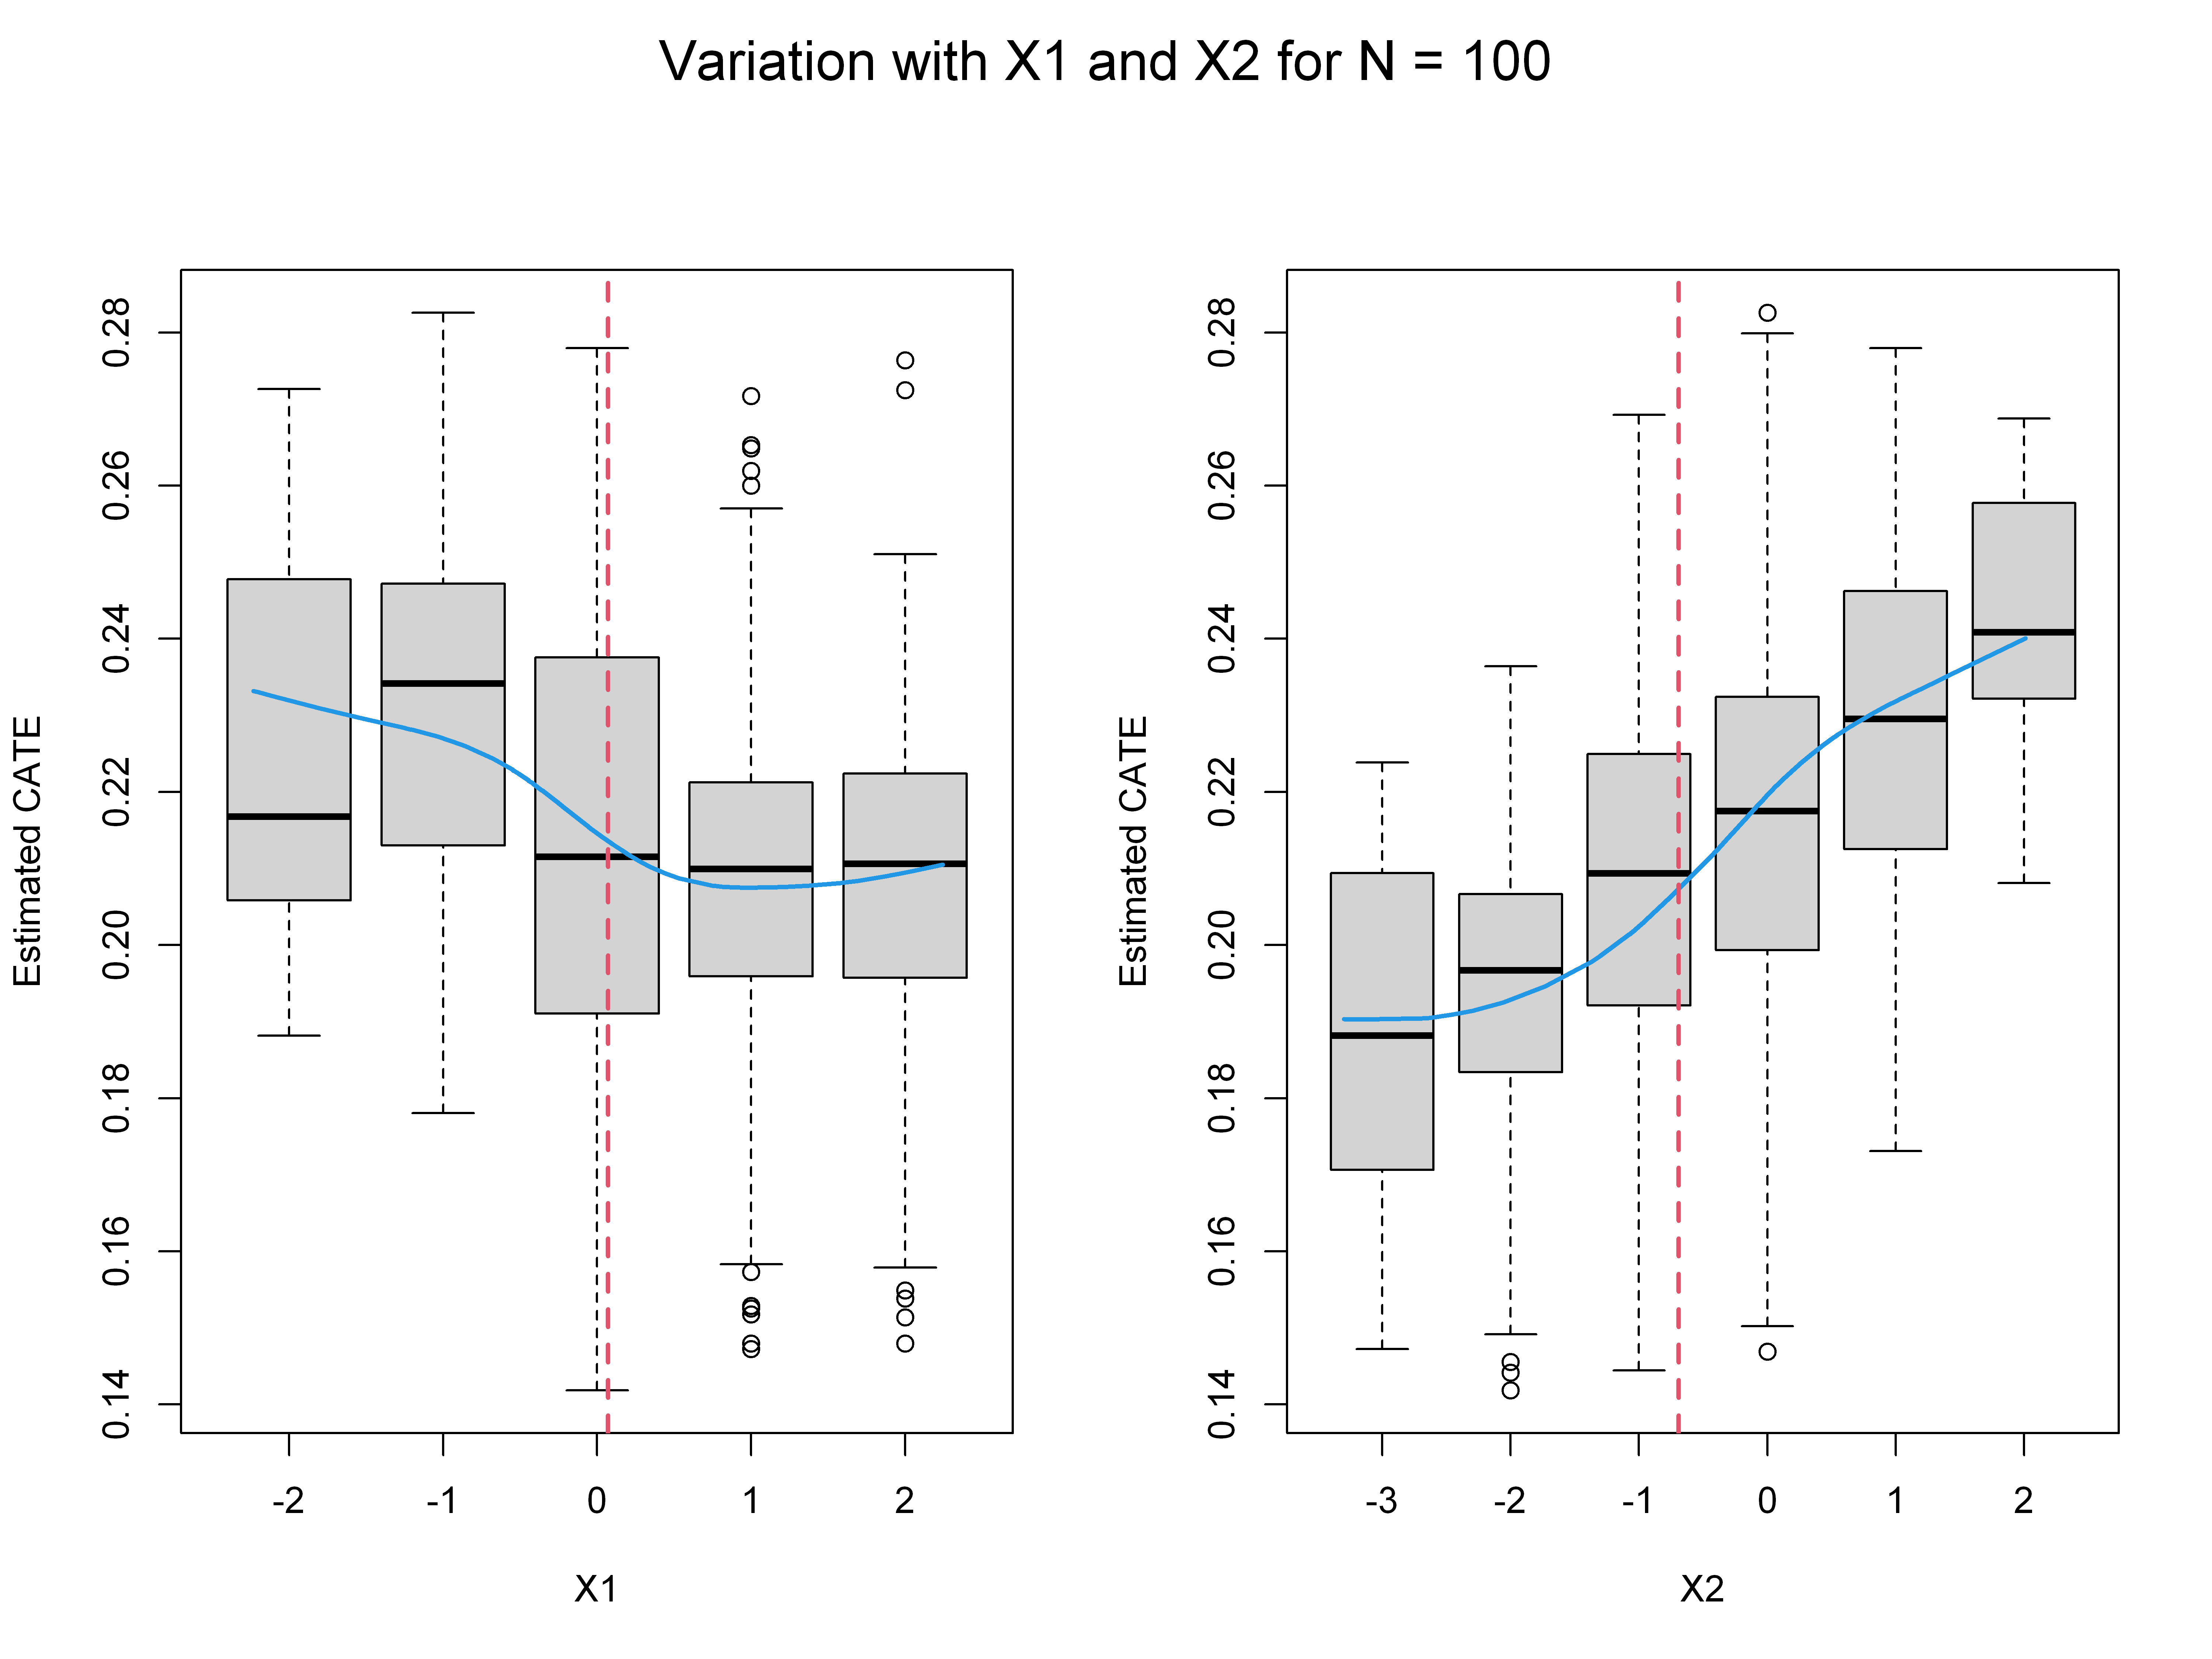

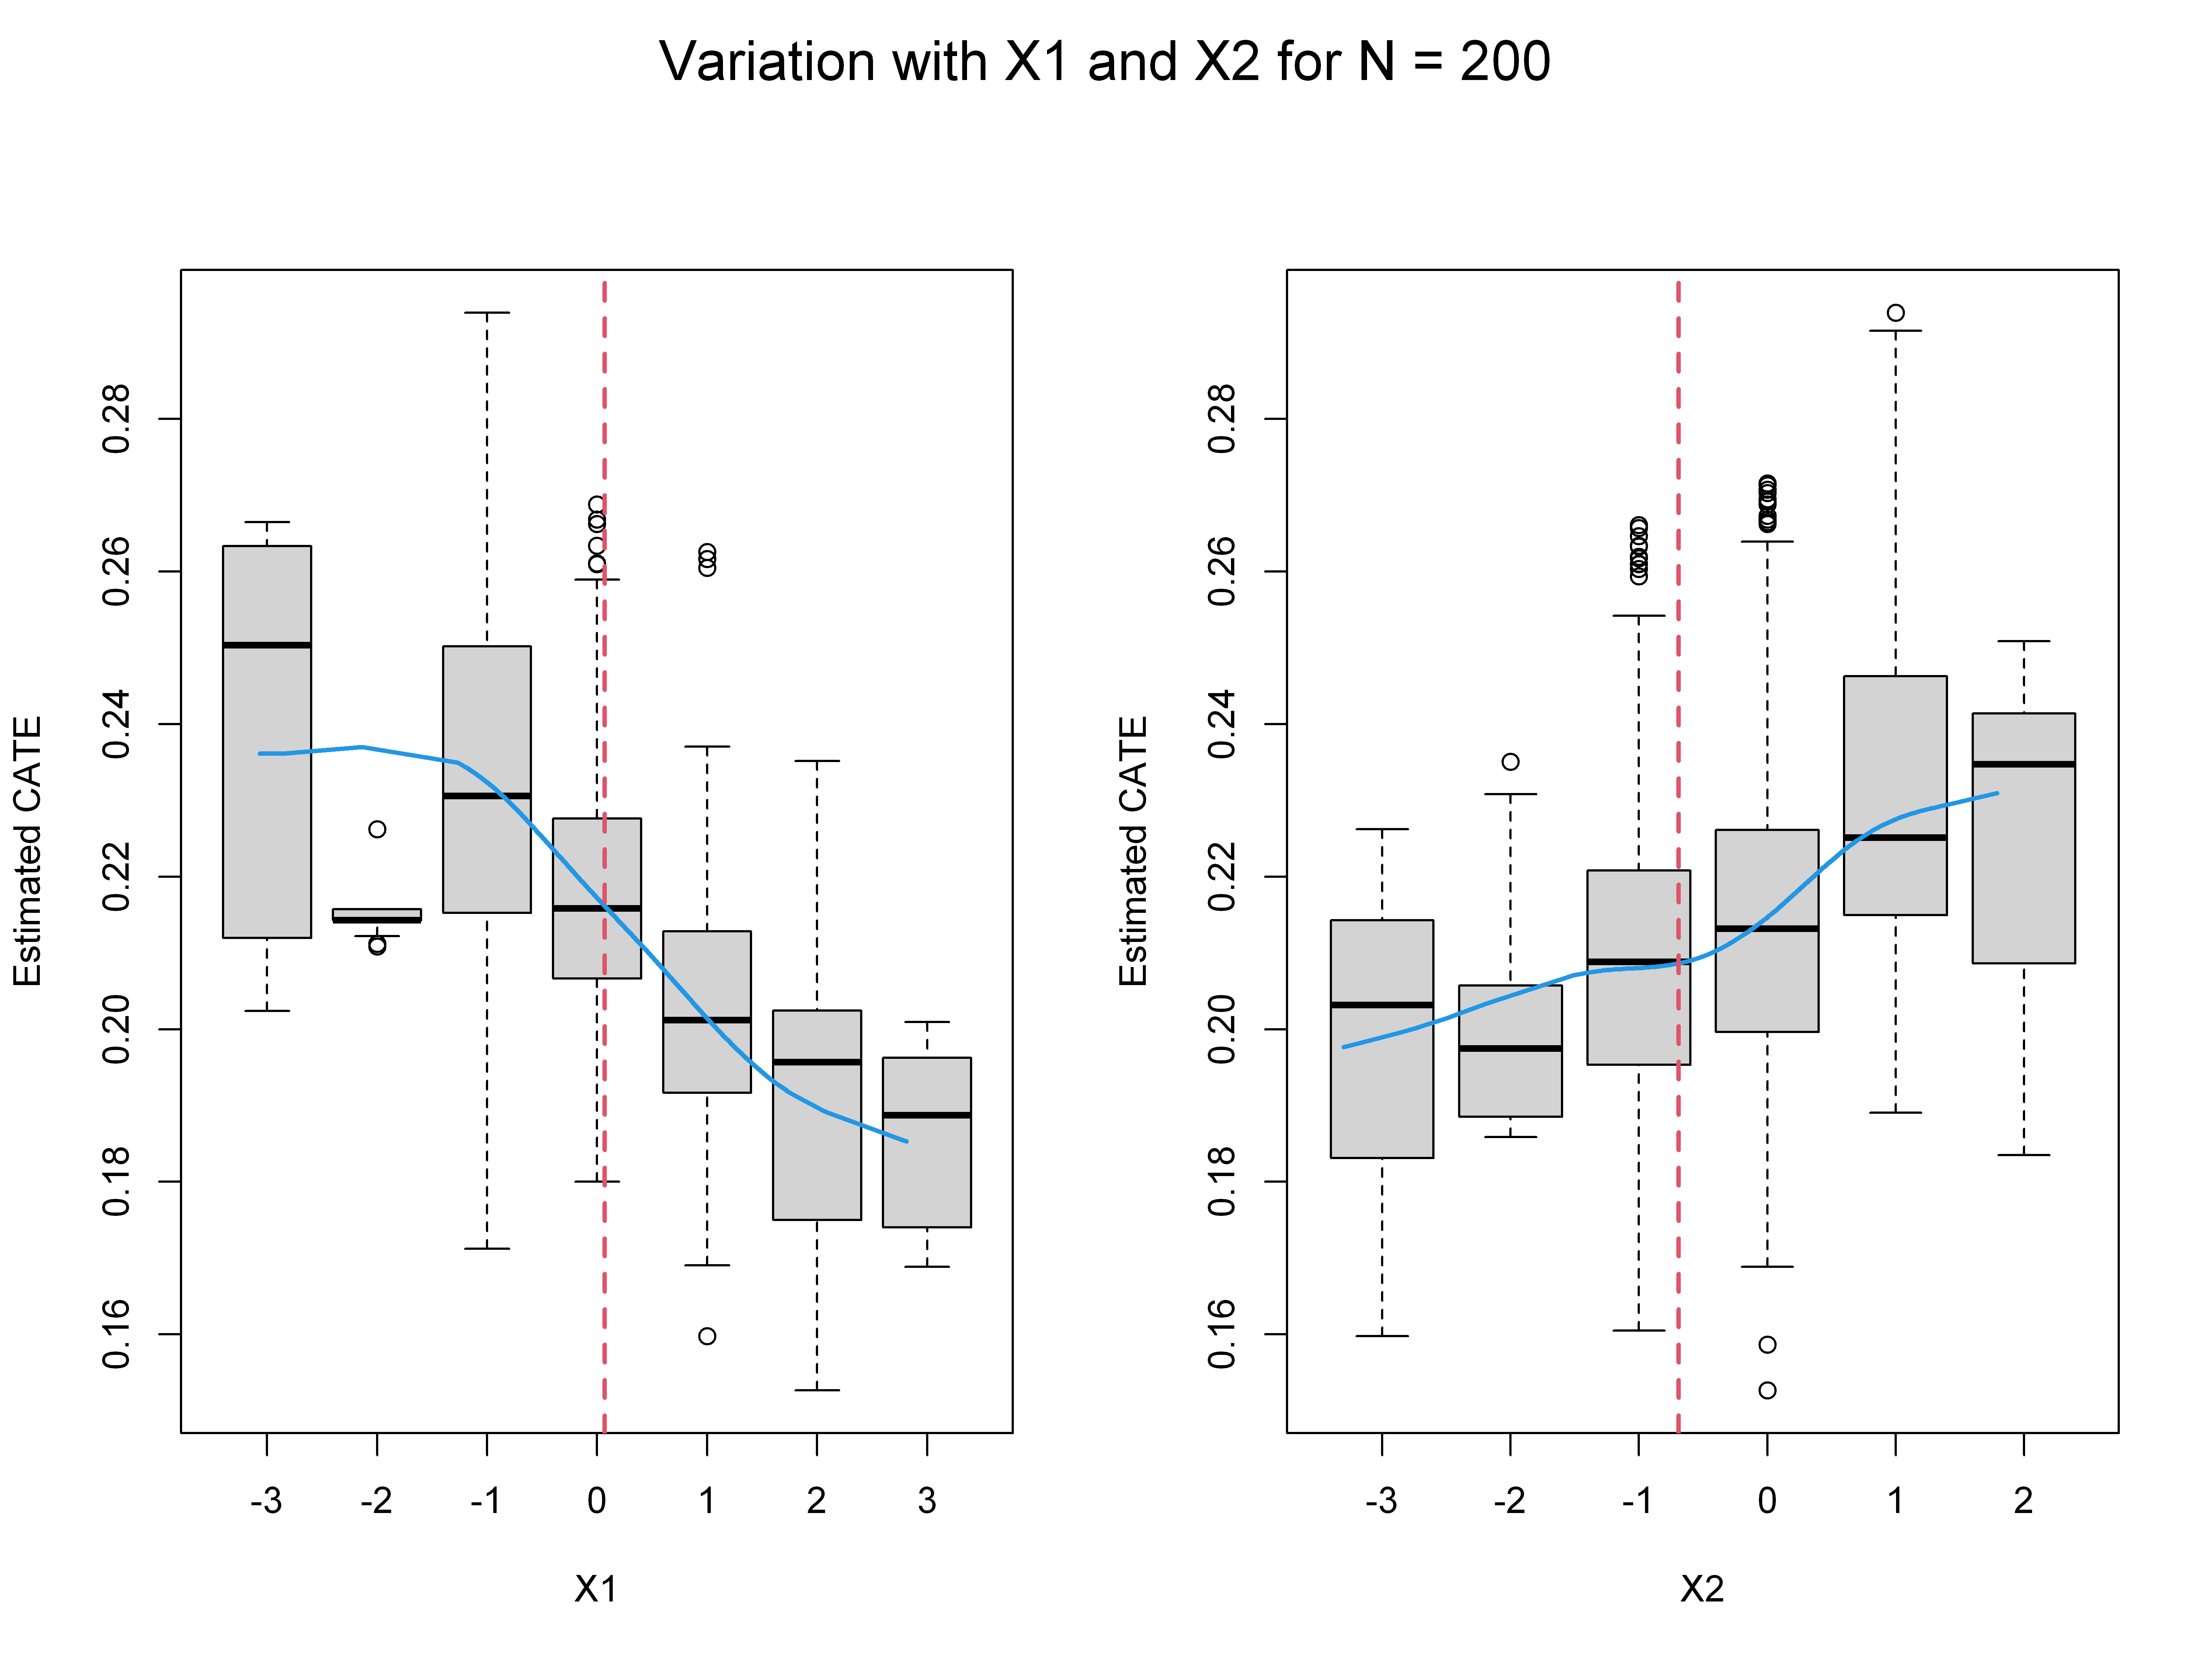

In [15]:
# Plots to investigate treatment moderation by X1 and X2
for (n in c(50, 76, 100, 200)) {
    CATE_X1_X2(n)
}

In [16]:
for (n in c(50, 76, 100, 200)){
    sim_data <- simulate_data(N = n)
    Y <- sim_data$Y
    W <- sim_data$W
    X <- sim_data[, -(1:3)]
    schoolid <- sim_data$schoolid
    
    C1_exp <- model.matrix(~ as.factor(X$C1) + 0)
    XC_exp <- model.matrix(~ as.factor(X$XC) + 0)
    X <- cbind(X[-c(2, 5)], C1_exp, XC_exp)
  
    lin_reg <- lm_robust(Y ~ W + X1*W + ., data = X[-c(9, 24)], clusters = schoolid, se_type = "CR0")
    out <- paste("Linear regression, N =", n, ": 95% CI for the coefficient of X1*W:", round(lin_reg$coefficients[3], 4),
             "+/-", round(qnorm(0.975)*lin_reg$std.error[3], 4))
  
    print(out)
}

[1] "Linear regression, N = 50 : 95% CI for the coefficient of X1*W: -0.0369 +/- 0.0554"
[1] "Linear regression, N = 76 : 95% CI for the coefficient of X1*W: -0.0585 +/- 0.0496"
[1] "Linear regression, N = 100 : 95% CI for the coefficient of X1*W: -0.0527 +/- 0.0283"
[1] "Linear regression, N = 200 : 95% CI for the coefficient of X1*W: -0.0822 +/- 0.0273"


In [17]:
for (n in c(50, 76, 100, 200)){
    sim_data <- simulate_data(N = n)
    Y <- sim_data$Y
    W <- sim_data$W
    X <- sim_data[, -(1:3)]
    schoolid <- sim_data$schoolid
    
    C1_exp <- model.matrix(~ as.factor(X$C1) + 0)
    XC_exp <- model.matrix(~ as.factor(X$XC) + 0)
    X <- cbind(X[-c(2, 5)], C1_exp, XC_exp)
  
    lin_reg <- lm_robust(Y ~ W + X2*W + ., data = X[-c(9, 24)], clusters = schoolid, se_type = "CR0")
    out <- paste("Linear regression, N =", n, ": 95% CI for the coefficient of X1*W:", round(lin_reg$coefficients[3], 4),
             "+/-", round(qnorm(0.975)*lin_reg$std.error[3], 4))
  
    print(out)
}

[1] "Linear regression, N = 50 : 95% CI for the coefficient of X1*W: 0.0088 +/- 0.0457"
[1] "Linear regression, N = 76 : 95% CI for the coefficient of X1*W: -0.0216 +/- 0.0398"
[1] "Linear regression, N = 100 : 95% CI for the coefficient of X1*W: -0.0337 +/- 0.0362"
[1] "Linear regression, N = 200 : 95% CI for the coefficient of X1*W: -0.0222 +/- 0.026"


Interpretation:

* The direction for the coefficient of X1 matches our suppose, but not for X2.
* This analysis uncovers notable heterogeneity along X1, i.e., schools with larger values of X1 appear to experience larger effects than schools with smaller values of X1. 
* Conversely, we do see heterogeneity along X2, but not in linear regression.
* See also Athey and Wager (2019).

### 2.2)
*Introduce other interactions to evaluate the scenario in question 3.*

In [18]:
CATE_X4_C1 <- function(N) {
    sim_data <- simulate_data(N = N)
    Y <- sim_data$Y
    W <- sim_data$W
    X <- sim_data[, -(1:3)]
    schoolid <- sim_data$schoolid
    
    C1_exp <- model.matrix(~ as.factor(X$C1) + 0)
    XC_exp <- model.matrix(~ as.factor(X$XC) + 0)
    X <- cbind(X[-c(2, 5)], C1_exp, XC_exp)
    
    Y_forest <- regression_forest(X, Y, clusters = schoolid, equalize.cluster.weights = TRUE)
    Y_hat <- predict(Y_forest)$predictions
    
    W_forest <- regression_forest(X, W, clusters = schoolid, equalize.cluster.weights = TRUE)
    W_hat <- predict(W_forest)$predictions
    
    cf_pilot <- causal_forest(X, Y, W,
                              Y.hat = Y_hat, W.hat = W_hat,
                              clusters = schoolid, equalize.cluster.weights = TRUE)
    
    var_imp <- variable_importance(cf_pilot) 
    select_index <- which(var_imp > mean(var_imp))
    
    cf <- causal_forest(X[, select_index], Y, W,
                        Y.hat = Y_hat, W.hat = W_hat,
                        clusters = schoolid, equalize.cluster.weights = TRUE,
                        tune.parameters = "all")
    
    tau_hat <- predict(cf)$predictions
    
    par(mfrow = c(1, 2), oma = c(0, 0, 2, 0))
    
    ifelse(min(round(X$X4)) == -2, a <- 3, a <- 4)
    
    boxplot(tau_hat ~ round(X$X4), xlab = "X4", ylab = "Estimated CATE")
    lines(smooth.spline(a + X[, "X4"], tau_hat, df = 4), lwd = 2, col = 4)
    boxplot(tau_hat ~ sim_data$C1, xlab = "C1", ylab = "Estimated CATE")
    lines(smooth.spline(sim_data$C1, tau_hat, df = 8), lwd = 2, col = 4)
    
    mtext(paste("Variation with X4 and C1 for N =", N), outer = TRUE, cex = 1.5)
}

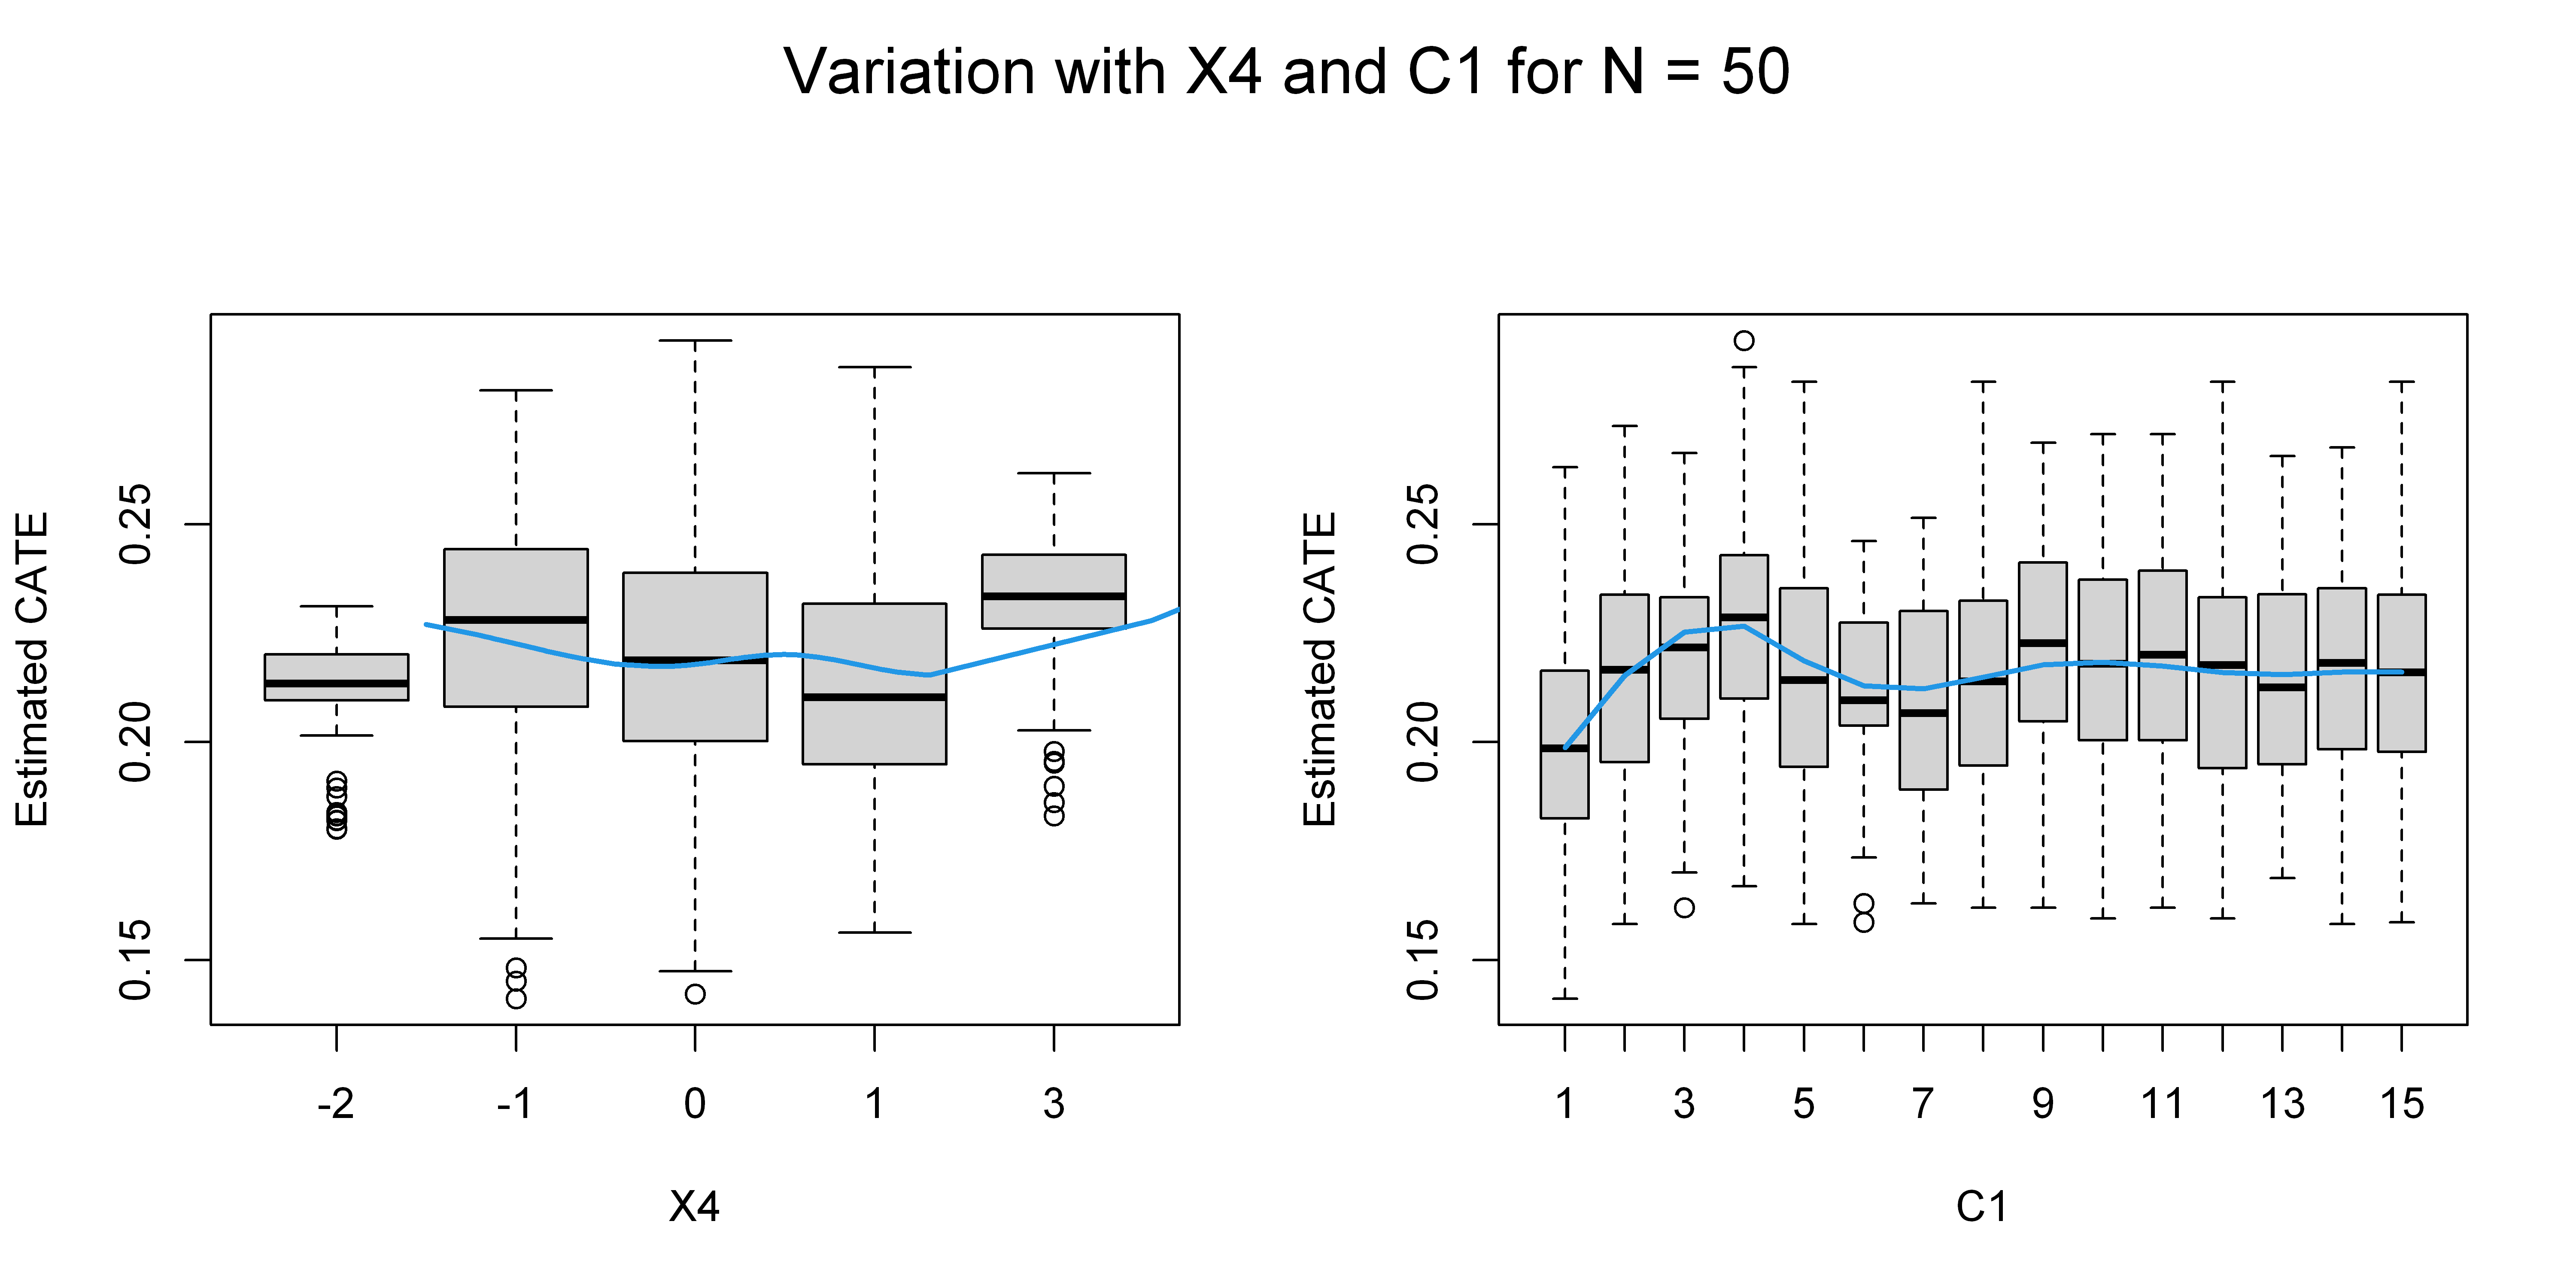

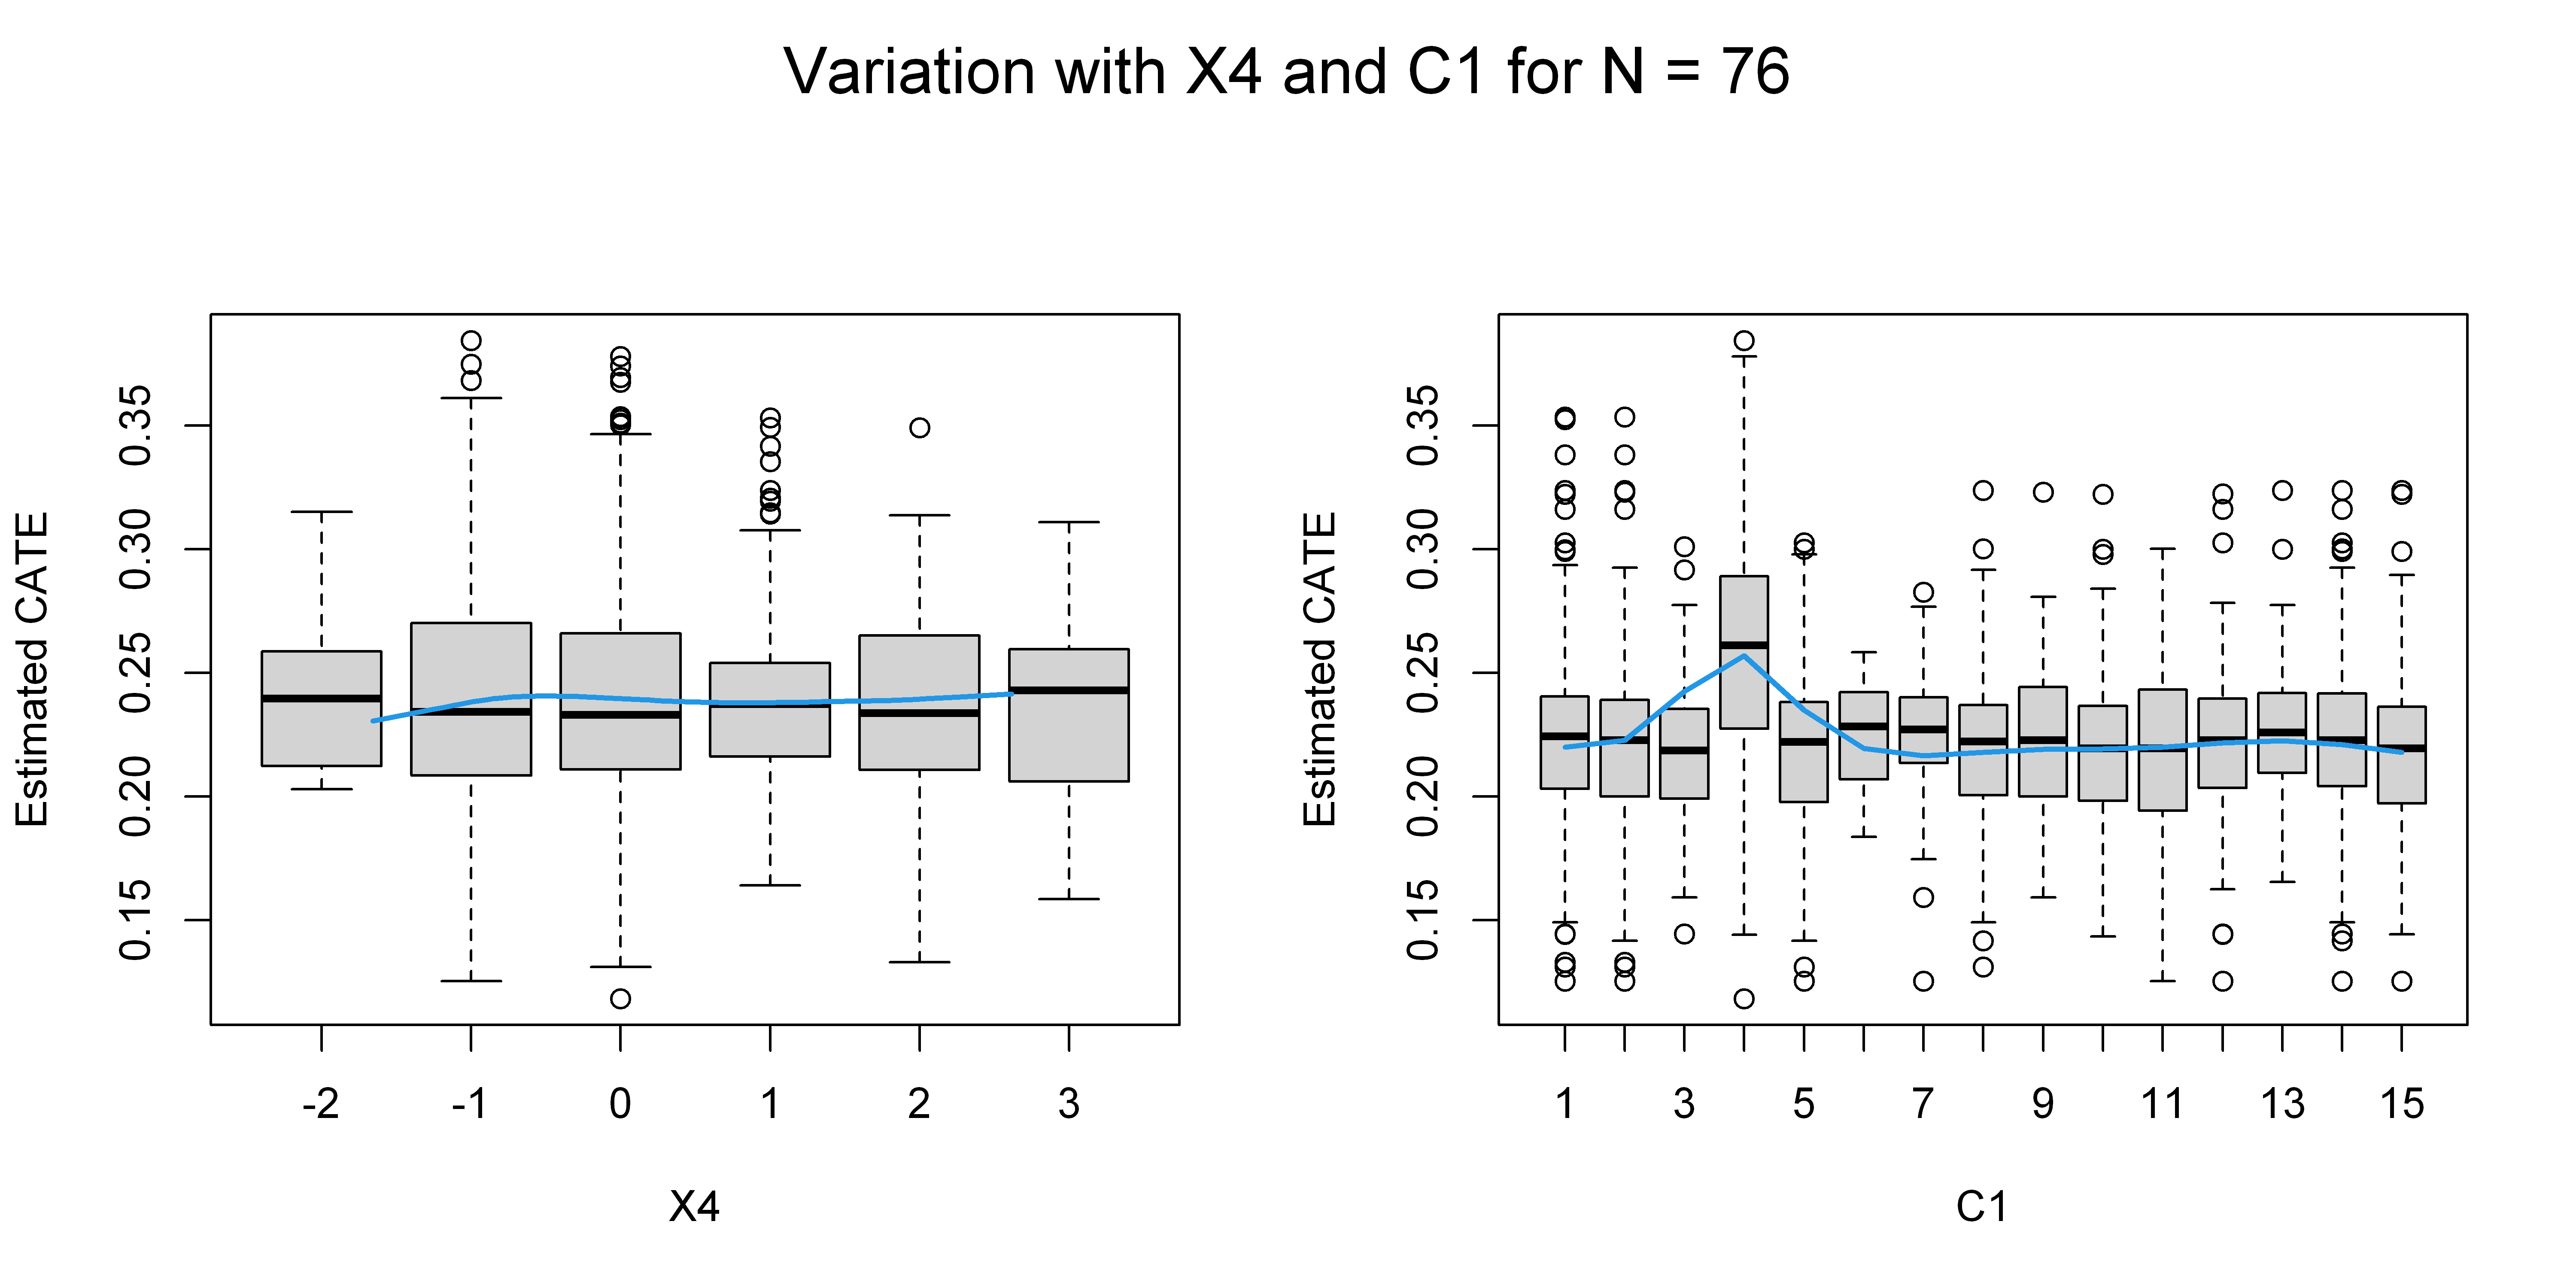

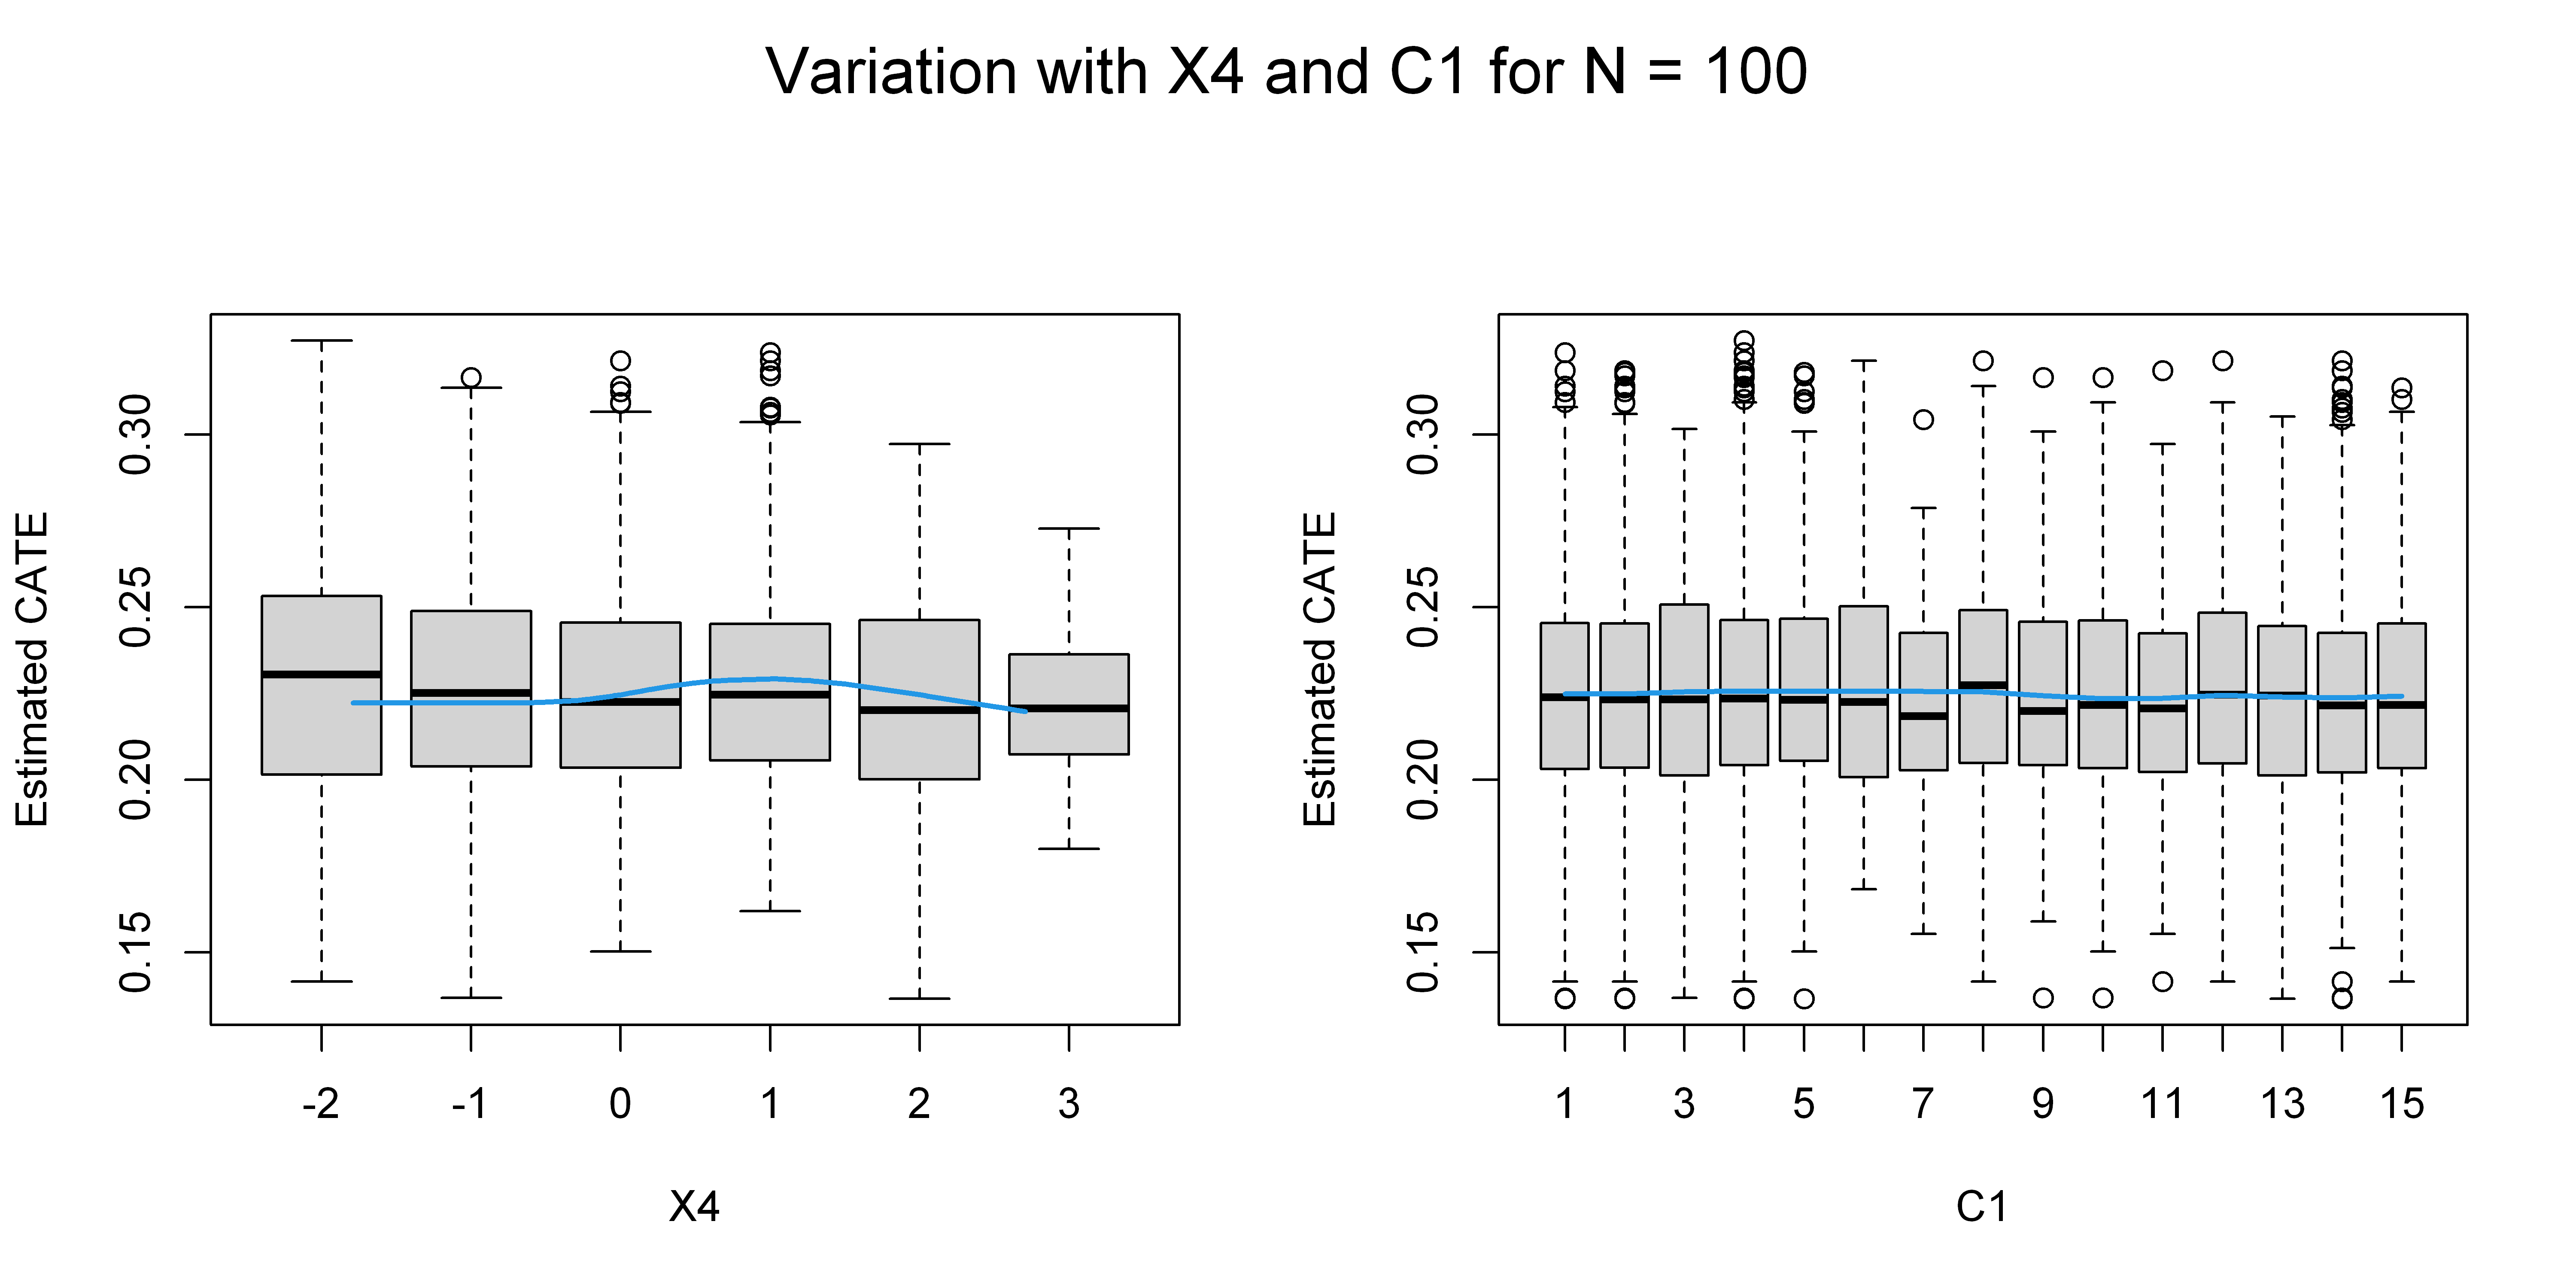

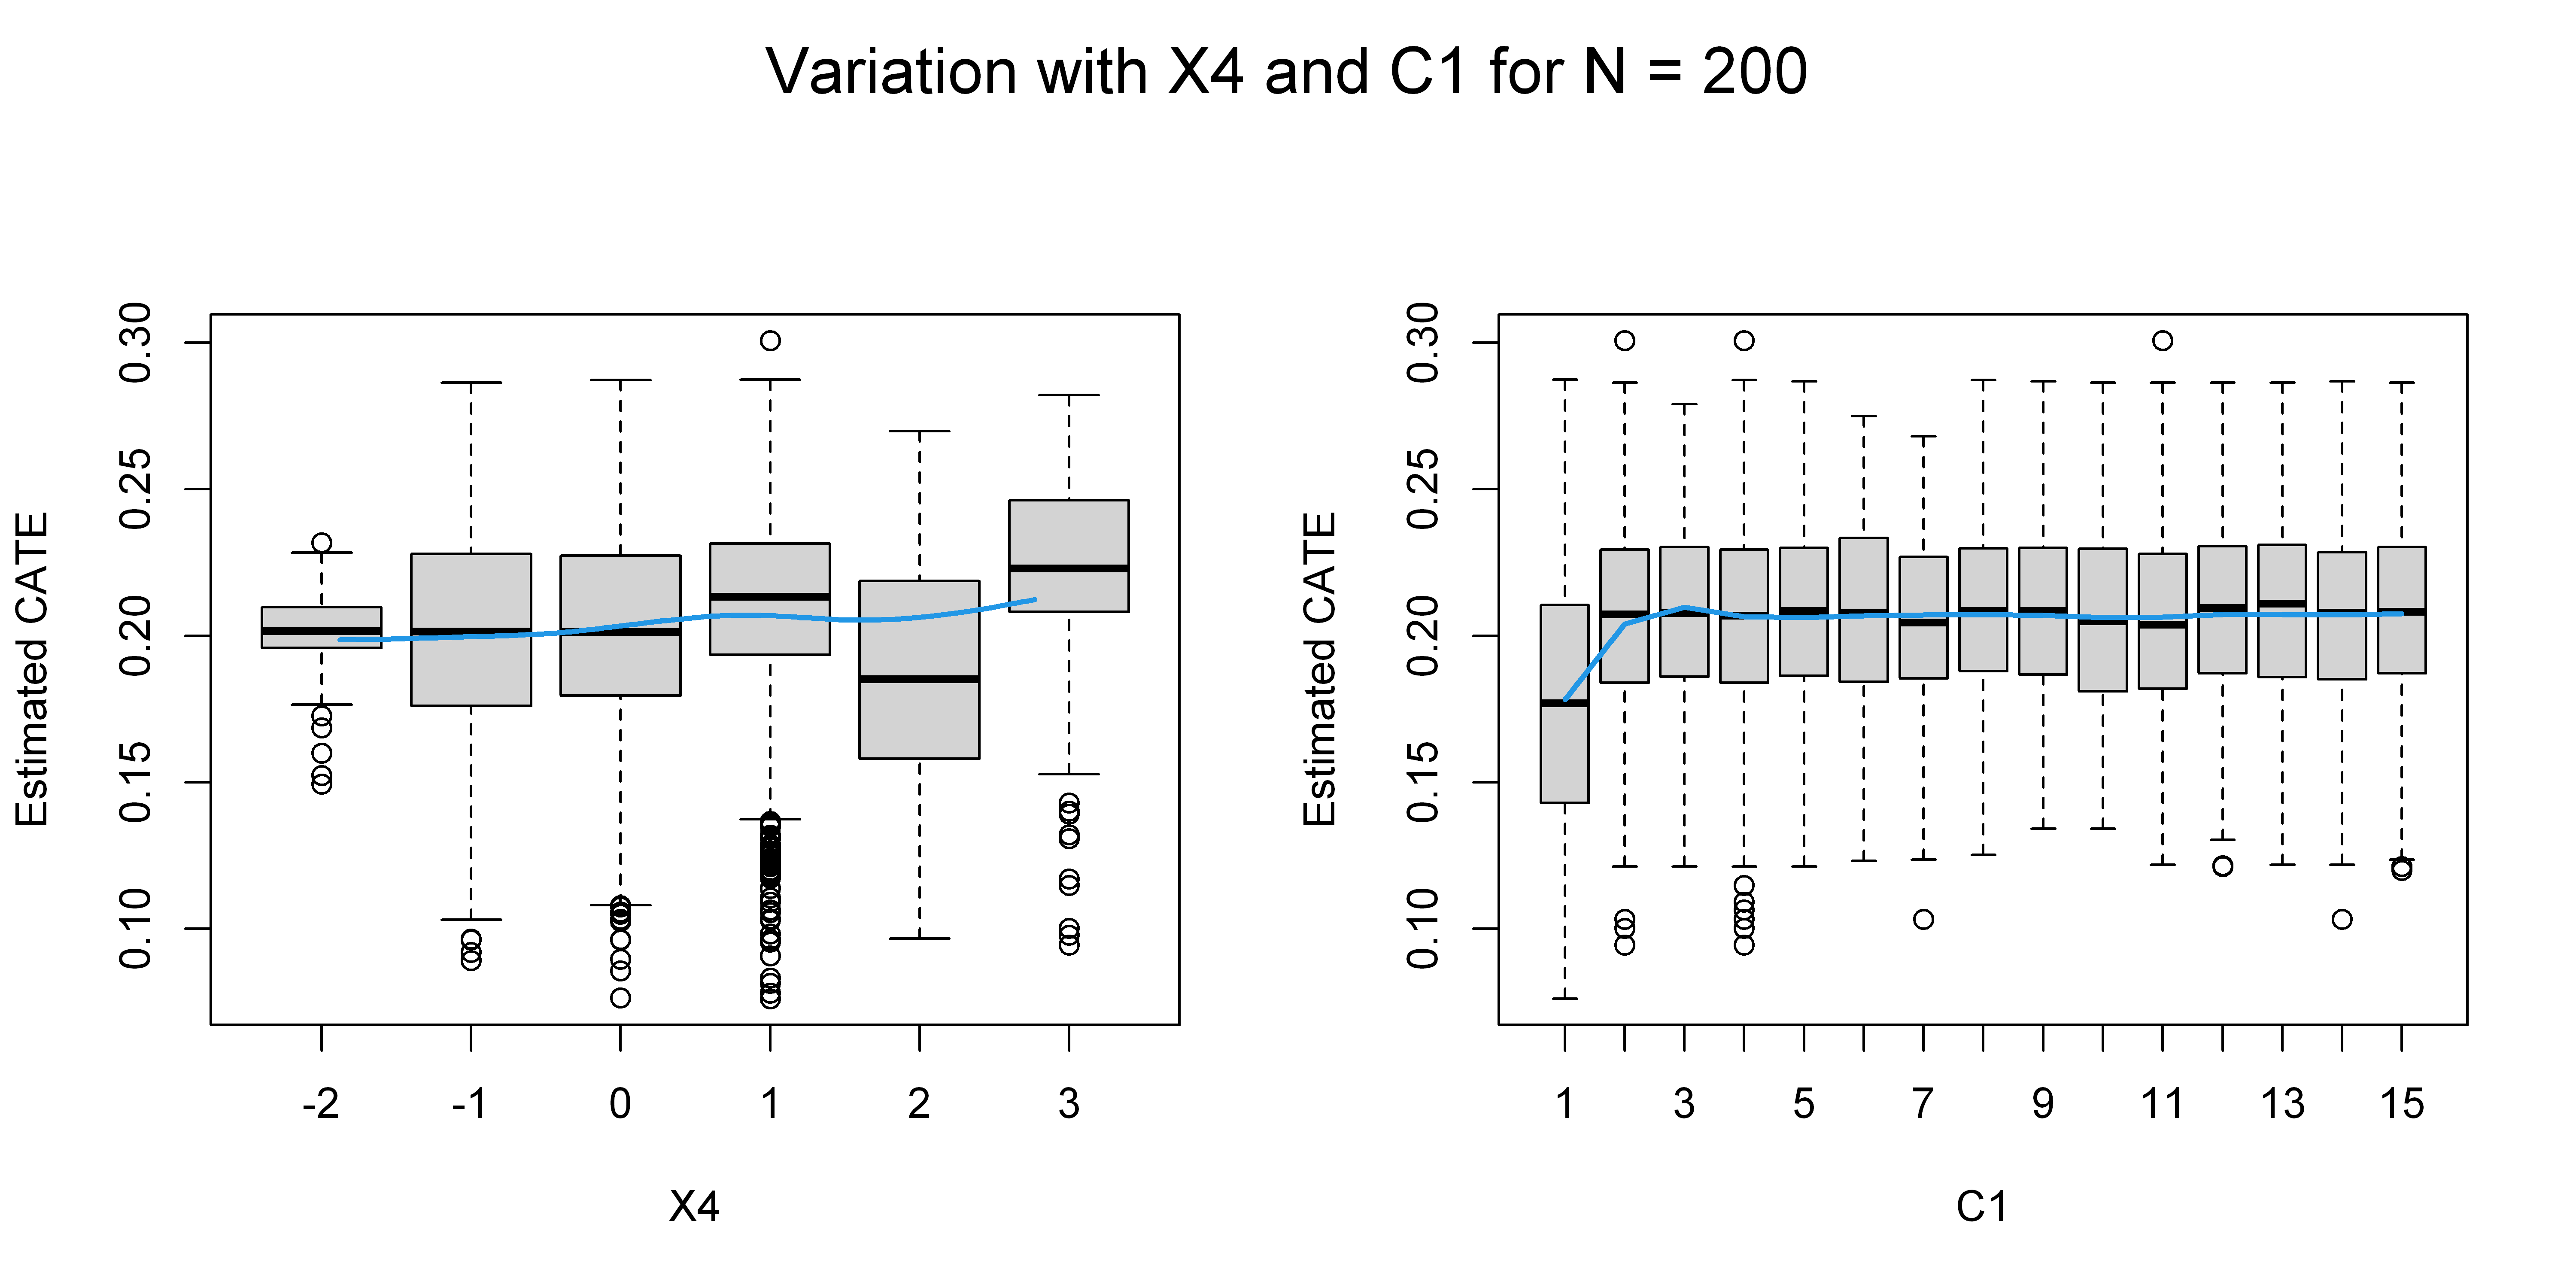

In [19]:
options(repr.plot.res = 600, repr.plot.height = 5, repr.plot.width = 10)

# Plots to investigate treatment moderation by X4 and C1
for (n in c(50, 76, 100, 200)) {
    CATE_X4_C1(n)
}

Interpretation:

* In our analysis, we cannot reveal any treatment effect variation by race. There should be some, but in the plots we cannot see any evidence for heterogeneity moderated by race. There are 15 classes, it is difficult to detect the heterogeneity.
* Also, no pattern for X4 is seen. This holds true as well for all further covariates (as expected from our simulation setup).